# <font color=#c51b8a>deepBreaks Applications</font>
### Modeling the phenotypes and spectral tuning sites of opsin proteins based on amino-acid sequence...  

# <font color=c994c7>Step 0: VPOD Setup w/SQLite</font>
### *The following function sets up the schema for our vizphiz database it doesn't yet exist. Otherwise it loads an existing version of VPOD stored locally.*
```

In [1]:
#All neccessary packages to import for data process steps.
import re
import os
import datetime 
import subprocess
import shutil 
import csv
import fileinput
from pathlib import Path

In [2]:
# edit vpod_root_path to point to the project directory
vpod_root_path = Path('../..').resolve()
vpod_scripts_path = vpod_root_path/'scripts_n_notebooks'
vpod_data_path = vpod_root_path/'vpod_data/VPOD_1.2'
from vpod_scripts.vpod_db import init_db

mydb = init_db(vpod_data_path/'vizphiz.db',vpod_data_path/'raw_database_files')

# <font color=c994c7>Step 1a: Extract Heterolgous Data Subsets From VPOD</font>
 - Output = 9 Different Data Subsets 

In [3]:
import pandas as pd
from deepBreaks.preprocessing import read_data
from vpod_scripts.extract_vpod_datasets import extract_vpod_datasets, get_mnm_datasets

seq_report_dir, data_split_list, meta_data_list, mnm_meta_list, mnm_meta_shorthand = extract_vpod_datasets(mydb)
print(f"VPOD datasets extracted to: {seq_report_dir}")

VPOD datasets extracted to: vpod_1.2_data_splits_2025-02-24_17-19-54


# <font color=c994c7>Step 1b: Create 'Inferred' Physiological Data Subsets From Mine-n-Match (MNM)</font>

### These datasets Consider Physiology Data (i.e. Single-Cell Microspectrophotemtry Readings) in Combination With the Heterologus Data From VPOD
 - Output is 5 extra datasets marked 'mnm' in the same folder directory created above ^ ('i.e. - The 'wt_mnm_meta.csv' file contains VPOD's heterolgous and MNM data)

 - The MNM pipeline (which you can find in this same folder) connects sequence to it's closest MSP value based on OPTICS predictions (our command-line tool for predicting opsin lambda max)
 
 - For more information, read our publication - HERE

In [4]:
path = './mine_n_match/mnm_data/mnm_on_mnm_on_all_dbs_2025-02-20_13-50-44'
mnm_file = f'{path}/mnm_on_vpod_acc_dbs_results_fully_filtered.csv'
mnm_data = read_data(mnm_file, seq_type = None, is_main=False)
# This function generates the 'mnm' datasets,
# which are a combination of the VPOD 'het' datasets and the corresponding 'mnm' data
data_split_list, meta_data_list = get_mnm_datasets(seq_report_dir, mnm_data, mnm_meta_list, mnm_meta_shorthand, meta_data_list, data_split_list)

# <font color=#c994c7>Step 2: Align Raw Data w/MAFFT and Format for 'deepBreaks'</font>
### REMINDER - You will need to change the directory for the 'mafft_exe' variable to the one of your own operating system!


In [5]:
from vpod_scripts.extract_vpod_datasets import perform_mafft_alignment
mafft_exe = 'C:/Users/safra/mafft-win/mafft.bat' 
deep_breaks_input_data = perform_mafft_alignment(data_split_list, mafft_exe)

['./vpod_1.2_data_splits_2025-02-24_17-19-54/wds_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/uss_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/mls_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/rod_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/vert_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/inv_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/wt_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/wt_vert_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/mut_only_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/wds_mnm_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/wt_mnm_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/vert_mnm_aligned_VPOD_1.2_het.fasta', './vpod_1.2_data_splits_2025-02-24_17-19-54/wt_vert_mn

# <font color=#c994c7>Step 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
 - **Output** = folder containing all results from model training, including comparison of model performances, an amino-acid site importance report + figures, and the top 5 trained models in a .pkl file format.

In [6]:
# importing deepBreaks libraries 
from deepBreaks.utils_alt2 import get_models, get_scores, get_params, get_empty_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 

In [7]:
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [8]:
# defining user params, file pathes, analysis type

#assign your path to folder containing all the datasplits
#path = './vpod_1.2_data_splits_2025-02-07_11-32-43'
path = f'./{seq_report_dir}'
# path to sequences of interest
seqFileName = f'{path}/wt_mnm_aligned_VPOD_1.2_het.fasta' 
# path to corresponding metadata of interest
metaDataFileName = f'{path}/wt_mnm_meta.csv' 
# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 

gap_threshold = 0.5

#Whether or not you want to drop the reference sequence from the training data- Usually 'Bovine' or 'Squid'
drop_ref = False


In [9]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('/')[2]
#print(seqFile)
seqFile = seqFile.split('.')[0]+'.'+seqFile.split('.')[1]
#print(seqFile)
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [10]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
# importing sequences data
print('reading fasta file')

tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=gap_threshold)

shutil.copy2(f'{seqFileName}',report_dir)
write_fasta(dat = tr, fasta_file = f'{seqFile}_gap_dropped.fasta' , report_dir = report_dir)

reading meta-data
reading fasta file
wt_mnm_aligned_VPOD_1.2_het_gap_dropped.fasta was saved successfully
CPU times: total: 609 ms
Wall time: 656 ms


In [11]:
try:
    reference_seq = tr.loc['Bovine'].copy()
    ref_seq_name = 'bovine'
    if drop_ref == True:
        meta_data = meta_data.drop('Bovine')
    #print(bovine)
except:
    reference_seq = tr.loc['Squid'].copy()
    ref_seq_name = 'squid'
    #print(squid)
reference_seq.to_csv(path_or_buf= f'{report_dir}/ref_sequence.csv',index = True,mode="w")

In [12]:
meta_data

Accession                      Species  Lambda_Max  \
Bovine  NM_001014890                    Bos_tarus       500.0   
S1          U57536.1            Neoniphon_sammara       502.0   
S2          U57540.1          Neoniphon_argenteus       502.0   
S3          U57541.1       Neoniphon_aurolineatus       481.0   
S4          U57543.1  Sargocentron_punctatissimum       494.0   
...              ...                          ...         ...   
MNM844      AF003543     Cambarellus_ludovicianus       529.0   
MNM845      AF000947            Sepia_officinalis       492.0   
MNM846      AD001674                Manduca_sexta       450.0   
MNM847      AB177984                 Pieris_rapae       540.0   
MNM848      AB007424               Papilio_xuthus       520.0   

                                                  Protein  
Bovine  MNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFL...  
S1      MNGTEGPYFYVPMVNTTGVVRSPYEYPQYYLVNPAAFAVLGAYMFF...  
S2      TEGPYFYVPMVNTTGIVRSPYEYPQYYLVNPAAYAVLGAYMFFLII...  
S3      TEGPDFYIPMVNTSGLVRSPYEYPQYYLVNPAAFAFLGAYMFFLII...  
S4      TEGPFFYIPMVNTSGVVRSPYEYPQYYLVNPAAYAILGAYMFFLII...  
...                                                   ...  
MNM844  LHMIHLHWYQYPPMNPMMYPLLLVFMLITGILCLAGNFVTIWVFMN...  
MNM845  MGRDIPDNETWWYNPTMEVHPHWKQFNQVPDAVYYSLGIFIGICGI...  
MNM846  MATNFTQELYEIGPMAYPLKMISKDVAEHMLGWNIPEEHQDLVHDH...  
MNM847  MAITNLDPAPGVAAMQSFGIHAEAFGSNQTVIDKVLPEMMHLIDPH...  
MNM848  MAIANLEPGMGASEAWGGQAAAFGSNQTVVDKVTPDMMHLIDPHWY...  

[849 rows x 4 columns]

In [13]:
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
tr.shape

(849, 355)

In [14]:
tr.head()

p1   p2   p3 p4 p5 p6 p7 p8 p9 p10  ... p346 p347 p348 p349 p350  \
Bovine    M    N    G  T  E  G  P  N  F   Y  ...  NaN  NaN    T    S    Q   
S1        M    N    G  T  E  G  P  Y  F   Y  ...    A  NaN  NaN    S    S   
S2      NaN  NaN  NaN  T  E  G  P  Y  F   Y  ...    A  NaN  NaN    S    S   
S3      NaN  NaN  NaN  T  E  G  P  D  F   Y  ...    A  NaN  NaN    S    S   
S4      NaN  NaN  NaN  T  E  G  P  F  F   Y  ...    A  NaN  NaN    S    S   

       p351 p352 p353 p354 Lambda_Max  
Bovine    V    A    P    A      500.0  
S1        V    S    P    A      502.0  
S2        V    S    P    A      502.0  
S3        V    S    P    A      481.0  
S4        V    S    P    A      494.0  

[5 rows x 355 columns]

In [15]:
import numpy as np
import csv
import pandas as pd

In [16]:
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

Shape of data is:  (849, 354)


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [17]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


Accession                      Species  Lambda_Max  \
Bovine  NM_001014890                    Bos_tarus       500.0   
S1          U57536.1            Neoniphon_sammara       502.0   
S2          U57540.1          Neoniphon_argenteus       502.0   
S3          U57541.1       Neoniphon_aurolineatus       481.0   
S4          U57543.1  Sargocentron_punctatissimum       494.0   

                                                  Protein  
Bovine  MNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFL...  
S1      MNGTEGPYFYVPMVNTTGVVRSPYEYPQYYLVNPAAFAVLGAYMFF...  
S2      TEGPYFYVPMVNTTGIVRSPYEYPQYYLVNPAAYAVLGAYMFFLII...  
S3      TEGPDFYIPMVNTSGLVRSPYEYPQYYLVNPAAFAFLGAYMFFLII...  
S4      TEGPFFYIPMVNTSGVVRSPYEYPQYYLVNPAAYAILGAYMFFLII...

In [18]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


p1   p2   p3 p4 p5 p6 p7 p8 p9 p10  ... p345 p346 p347 p348 p349  \
Bovine    M    N    G  T  E  G  P  N  F   Y  ...  NaN  NaN  NaN    T    S   
S1        M    N    G  T  E  G  P  Y  F   Y  ...    S    A  NaN  NaN    S   
S2      NaN  NaN  NaN  T  E  G  P  Y  F   Y  ...    S    A  NaN  NaN    S   
S3      NaN  NaN  NaN  T  E  G  P  D  F   Y  ...    S    A  NaN  NaN    S   
S4      NaN  NaN  NaN  T  E  G  P  F  F   Y  ...    S    A  NaN  NaN    S   

       p350 p351 p352 p353 p354  
Bovine    Q    V    A    P    A  
S1        S    V    S    P    A  
S2        S    V    S    P    A  
S3        S    V    S    P    A  
S4        S    V    S    P    A  

[5 rows x 354 columns]

In [19]:
y_ev = 1239.8 / np.array(y)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [20]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.01)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.01, keep=False))
    ])

In [21]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type, dataset='wt'),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=report_dir)

Fitting rf...
Fitting gbr...
Fitting BayesianRidge...
Fitting xgb...
CPU times: total: 5.06 s
Wall time: 41.7 s


MAE = Mean Absolute Error

MSE = Mean Squared Error

RMSE = Rooted Mean Square Error

MAPE = Mean Absolute % Error - the average magnitude of error produced by a model, or how far off predictions are on average. A MAPE value of 20% means that the average absolute percentage difference between the predictions and the actuals is 20%

In [22]:
report

R2       MAE         MSE       RMSE      MAPE
gbr            0.960593  6.942124  117.023677  10.679904  0.014808
rf             0.957981  7.082350  125.027349  10.984497  0.015118
xgb            0.951142  7.583397  143.723691  11.727298  0.016021
BayesianRidge  0.948846  8.286912  152.578116  12.186632  0.017588

In [23]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.01, keep=True))
    ])

In [24]:
modified_top = []
mtml = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
    my_top_models = str(model[1:])
    #print(my_top_models)
    my_top_models = my_top_models.split("'")[3]
    mtml.append(my_top_models)
    #print(my_top_models)

In [25]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.1, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.01))])),
                ('gbr',
                 GradientBoostingRegressor(max_depth=5, max_features='sqrt',
                                           n_estimators=200,
                                           random_state=123))])

In [26]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_empty_params(),report_dir=report_dir, cv=10)


Tuning gbr...
No Grid-Search Specified, fitting model to default parameters.
Tuning rf...
No Grid-Search Specified, fitting model to default parameters.
Tuning xgb...
No Grid-Search Specified, fitting model to default parameters.
Tuning BayesianRidge...
No Grid-Search Specified, fitting model to default parameters.
CPU times: total: 43.5 s
Wall time: 13.5 s


In [27]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: total: 1.53 s
Wall time: 1.83 s


In [28]:
sr.head()

feature       p_value      score       gbr        rf       xgb  \
0                p1_M  6.607686e-01   0.192727  0.000000  0.000000  0.000000   
1                p1_P  7.443091e-04  11.458735  0.006234  0.021059  0.007703   
2  p1_QAVLFEHINYGDCWS  6.000742e-05  16.266129  0.000216  0.003304  0.000146   
3                p1_T  2.593559e-01   1.273900  0.000000  0.000000  0.000000   
4                p2_G  3.706393e-13  54.505897  0.001629  0.001596  0.001888   

   BayesianRidge      mean  
0       0.000000  0.000000  
1       0.177442  0.053109  
2       0.092438  0.024026  
3       0.000000  0.000000  
4       0.272867  0.069495

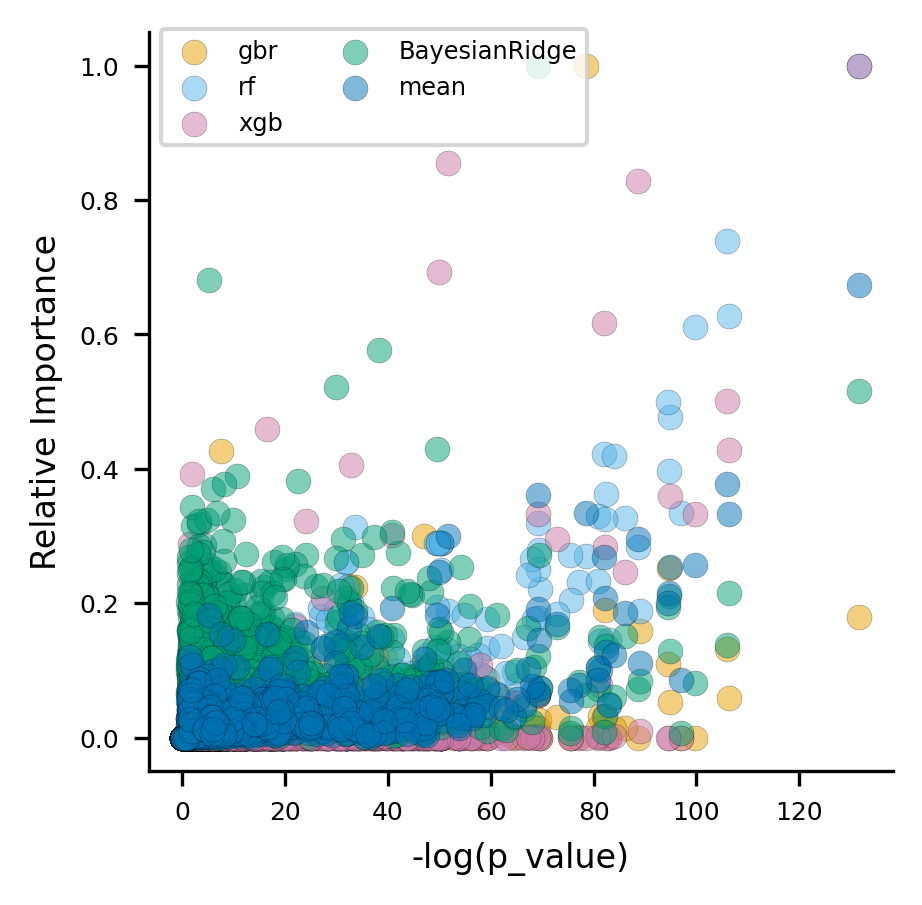

In [29]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [30]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: total: 141 ms
Wall time: 188 ms


mean Done


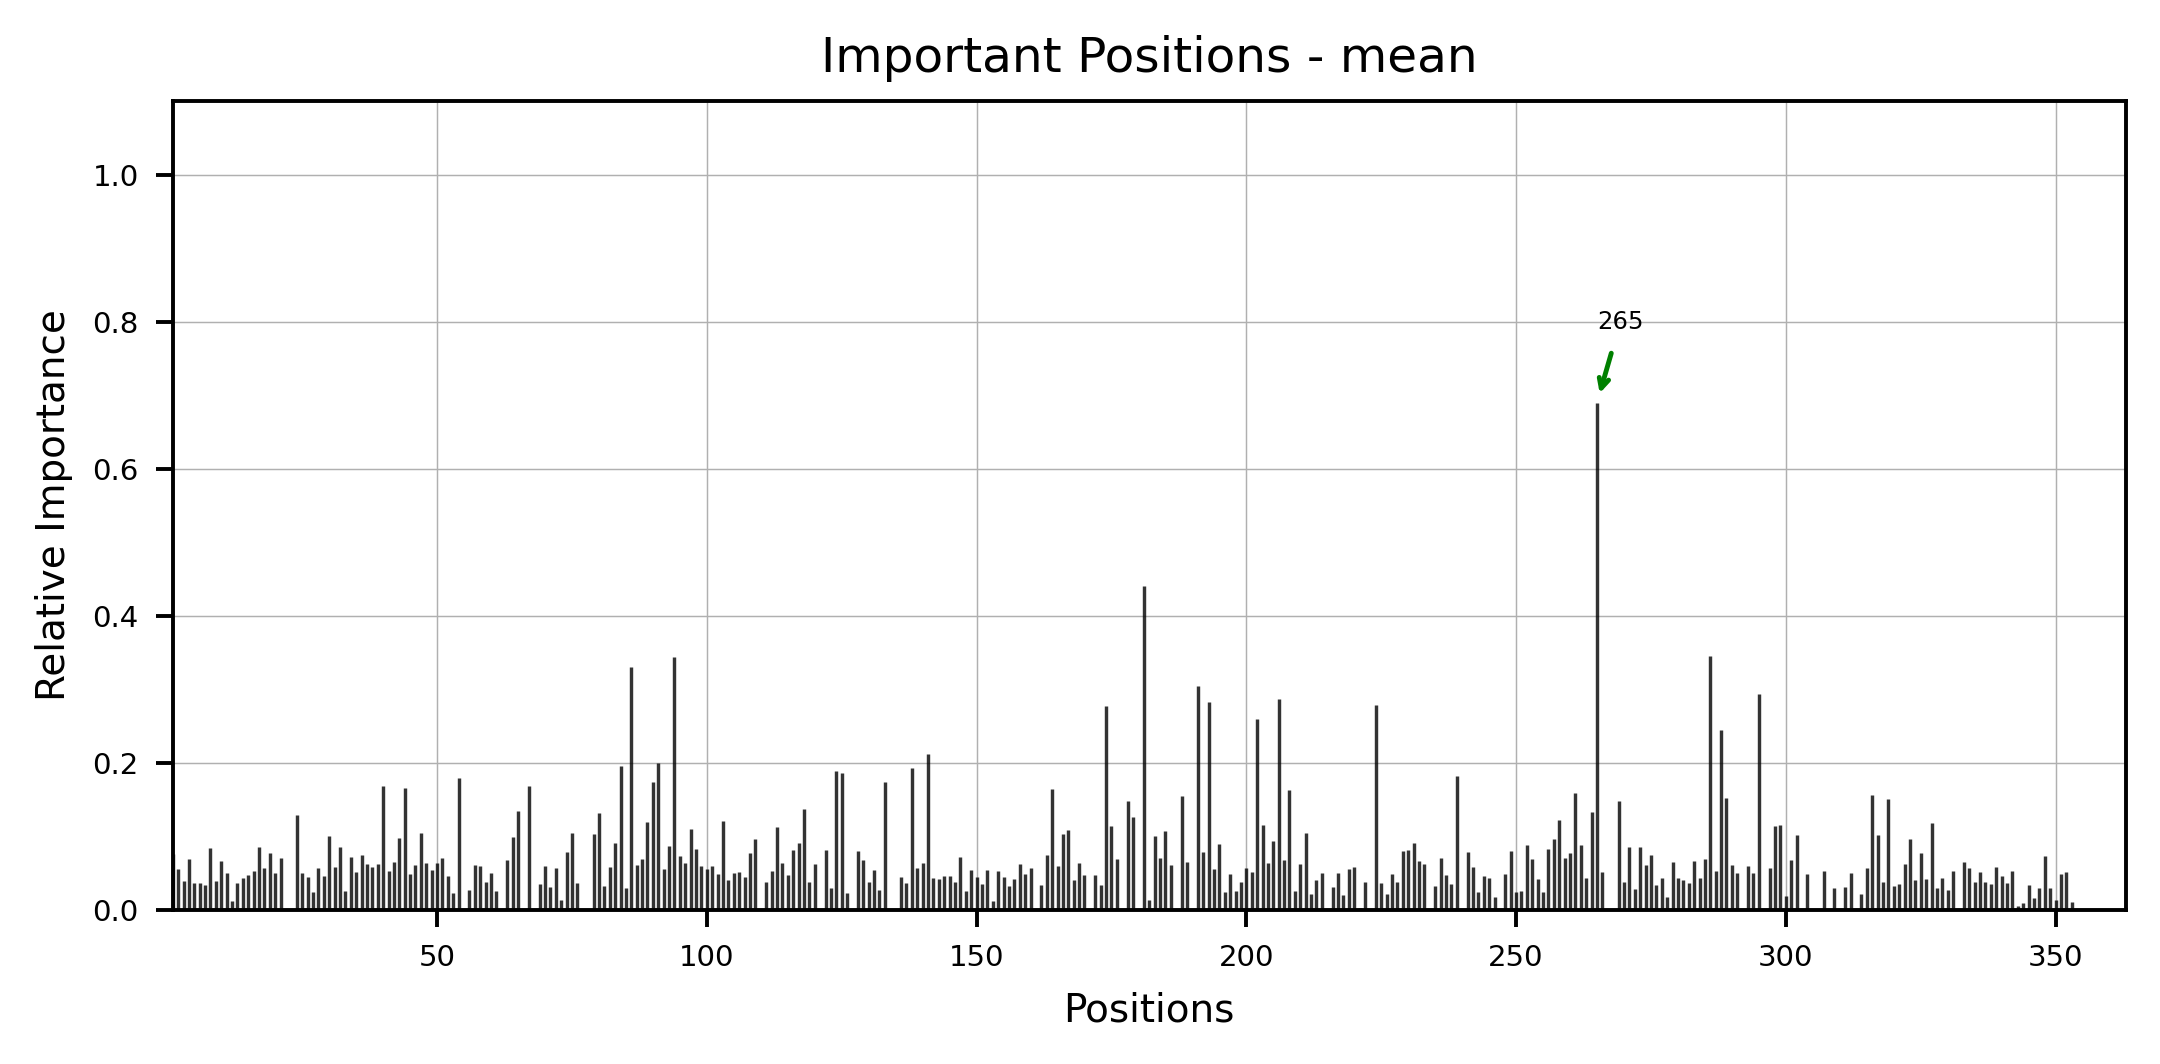

In [31]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [32]:
test_copy = tr.copy()

In [33]:
test_copy = prep_pipeline[:4].fit_transform(tr)

gbr Done
gbr  Done
rf Done
rf  Done
xgb Done
xgb  Done
BayesianRidge Done
BayesianRidge  Done


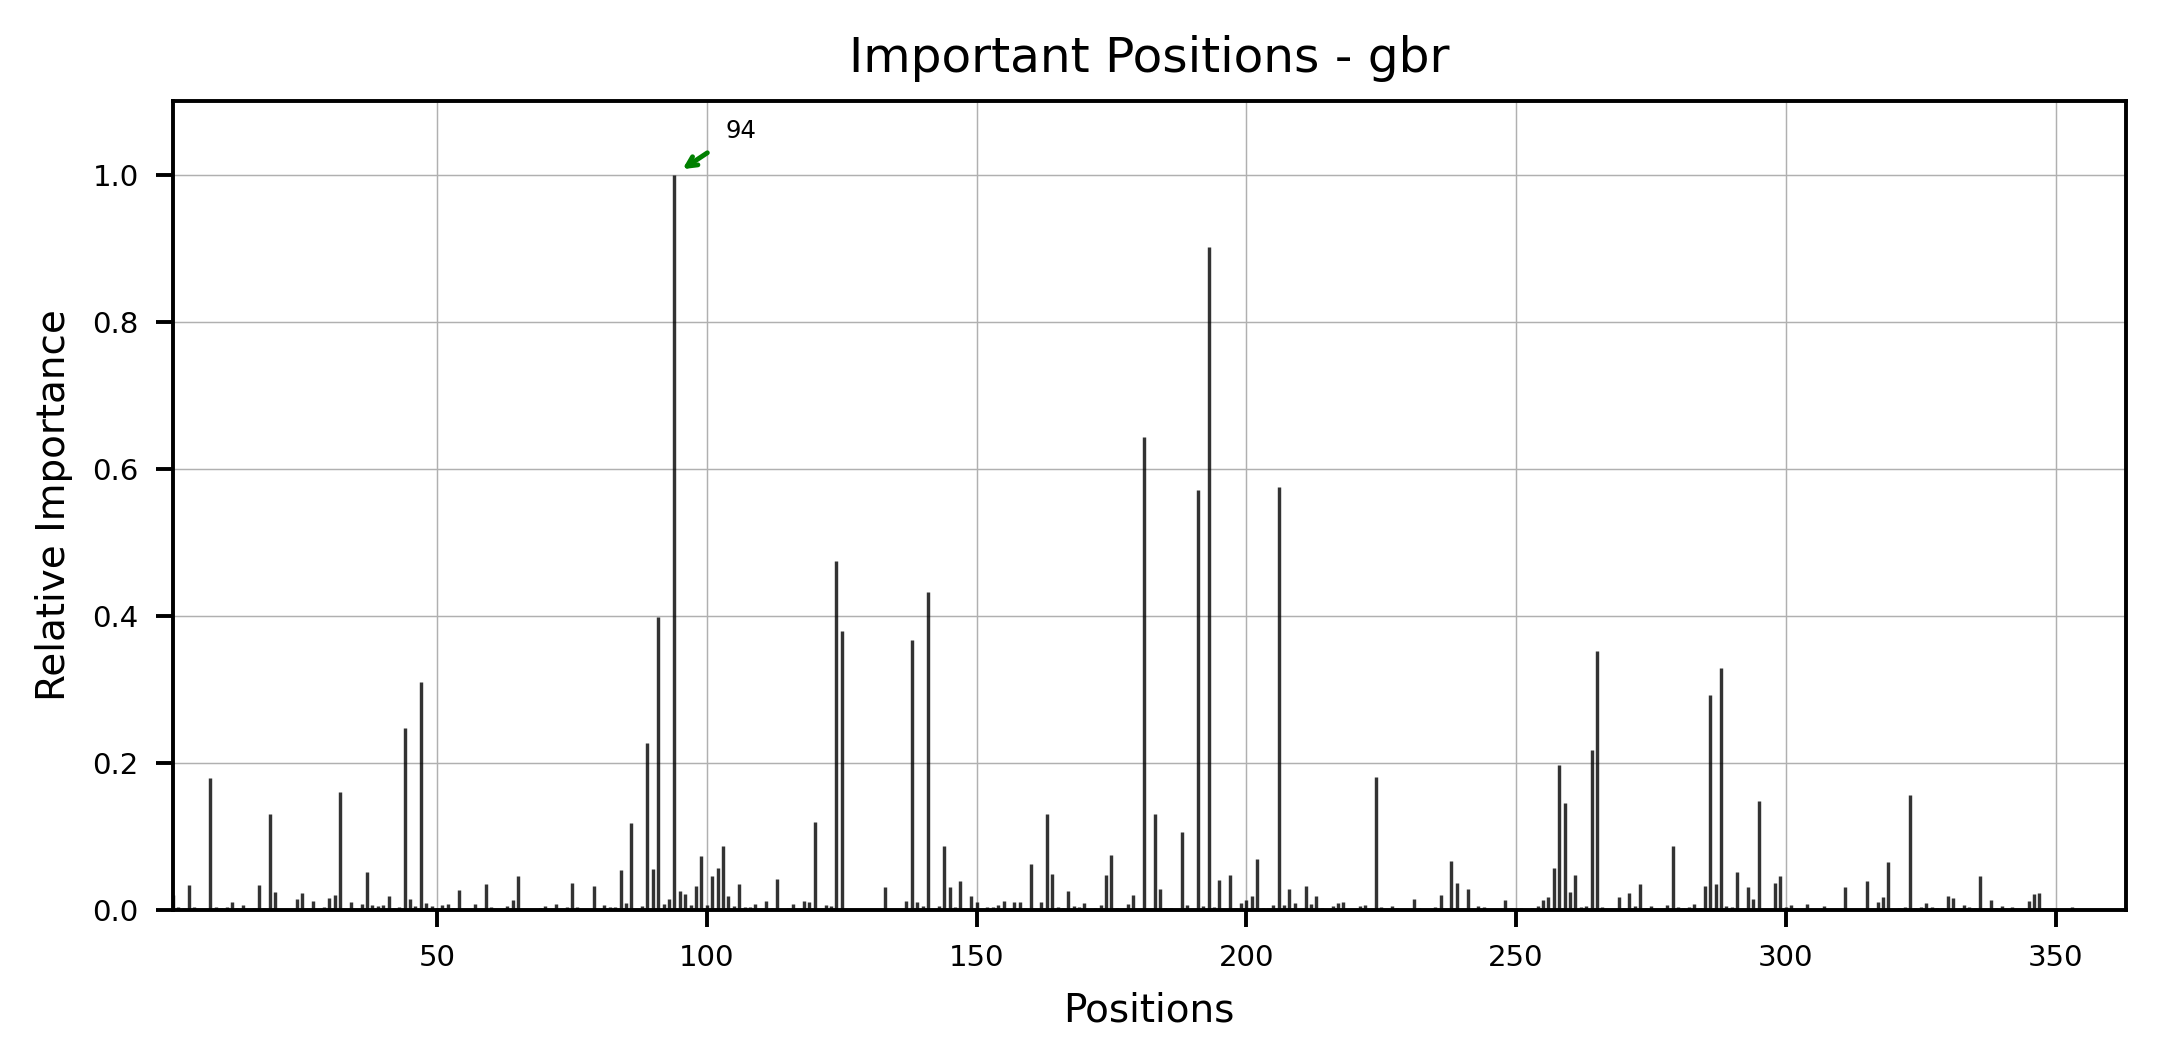

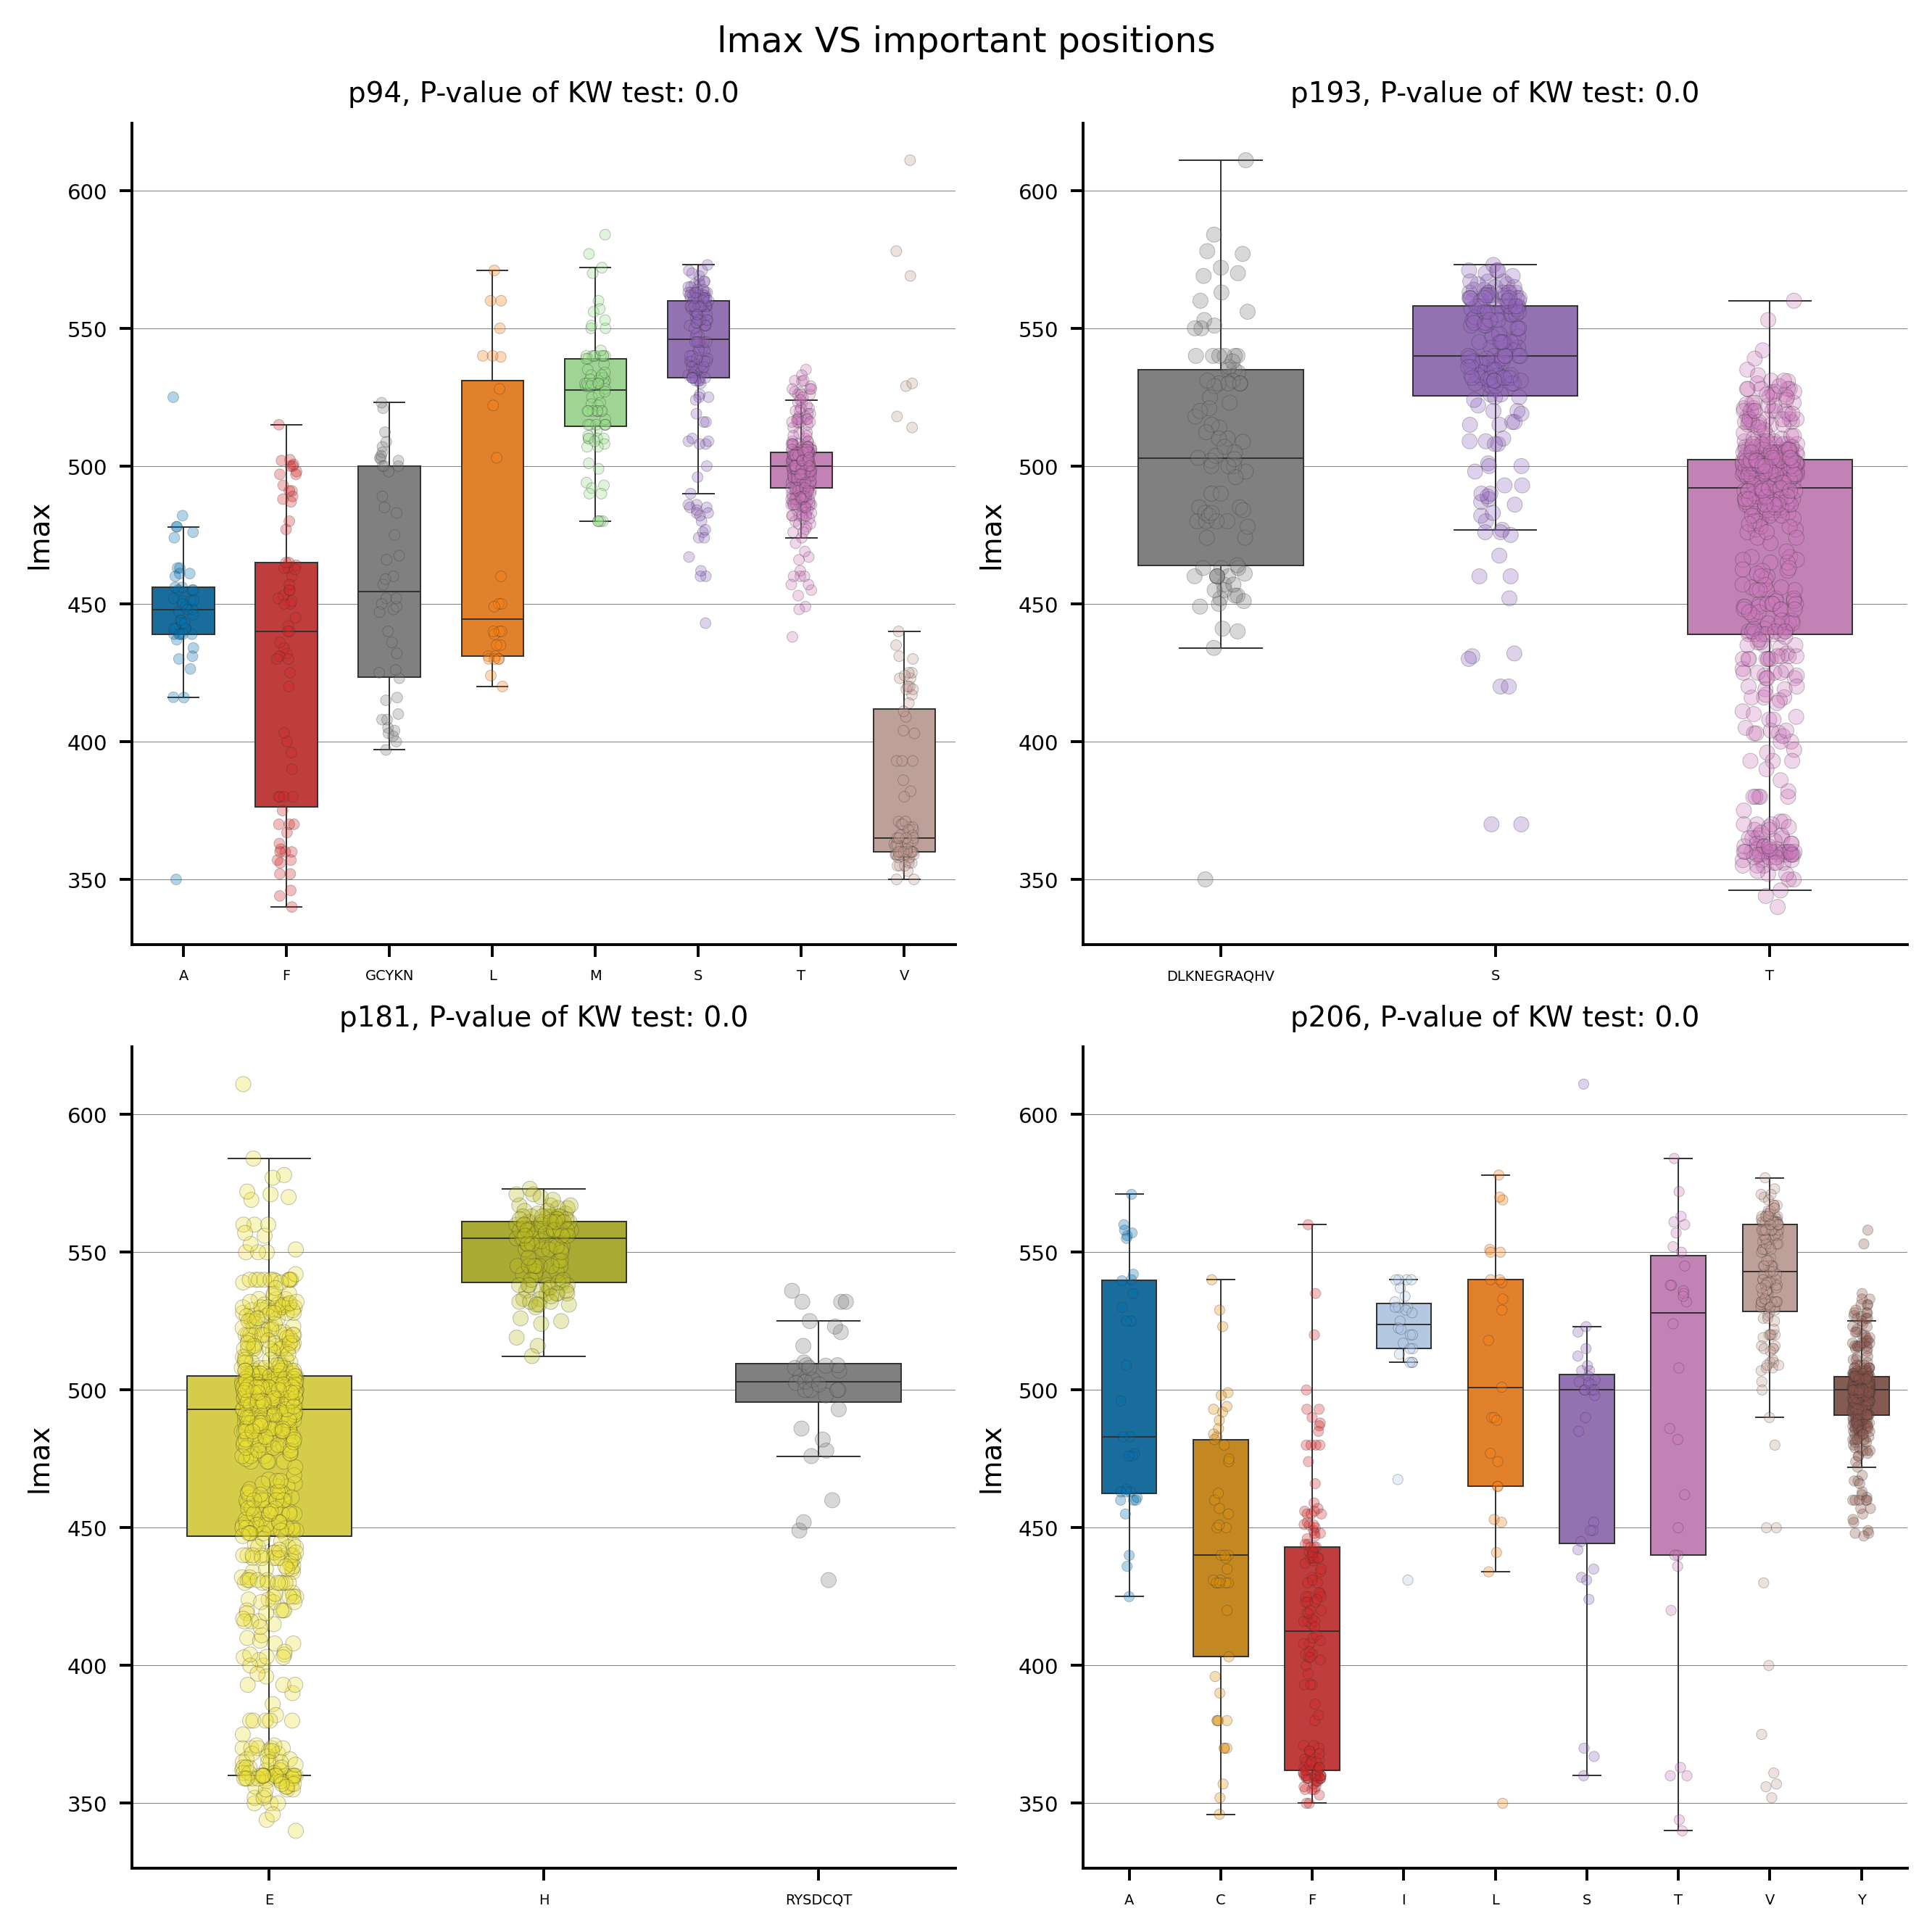

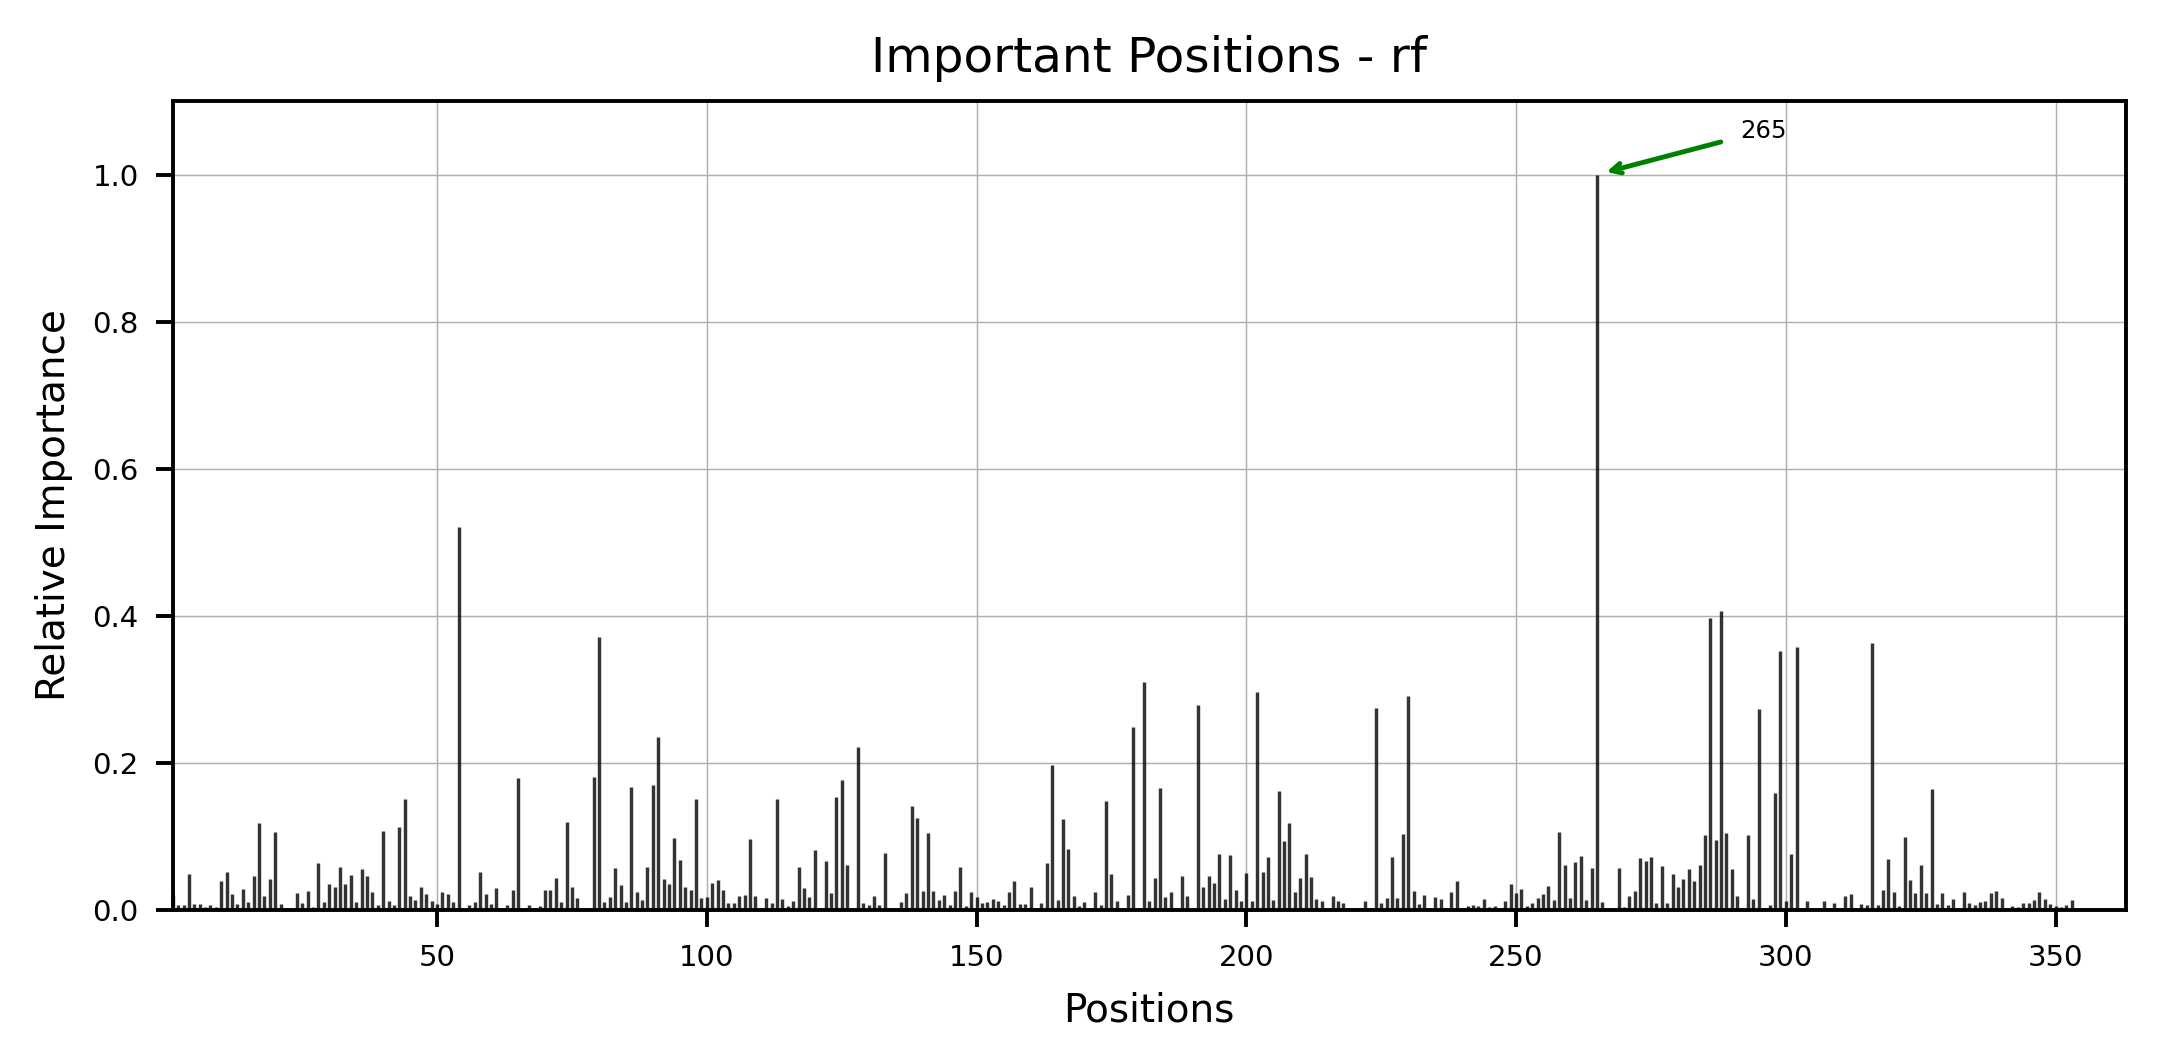

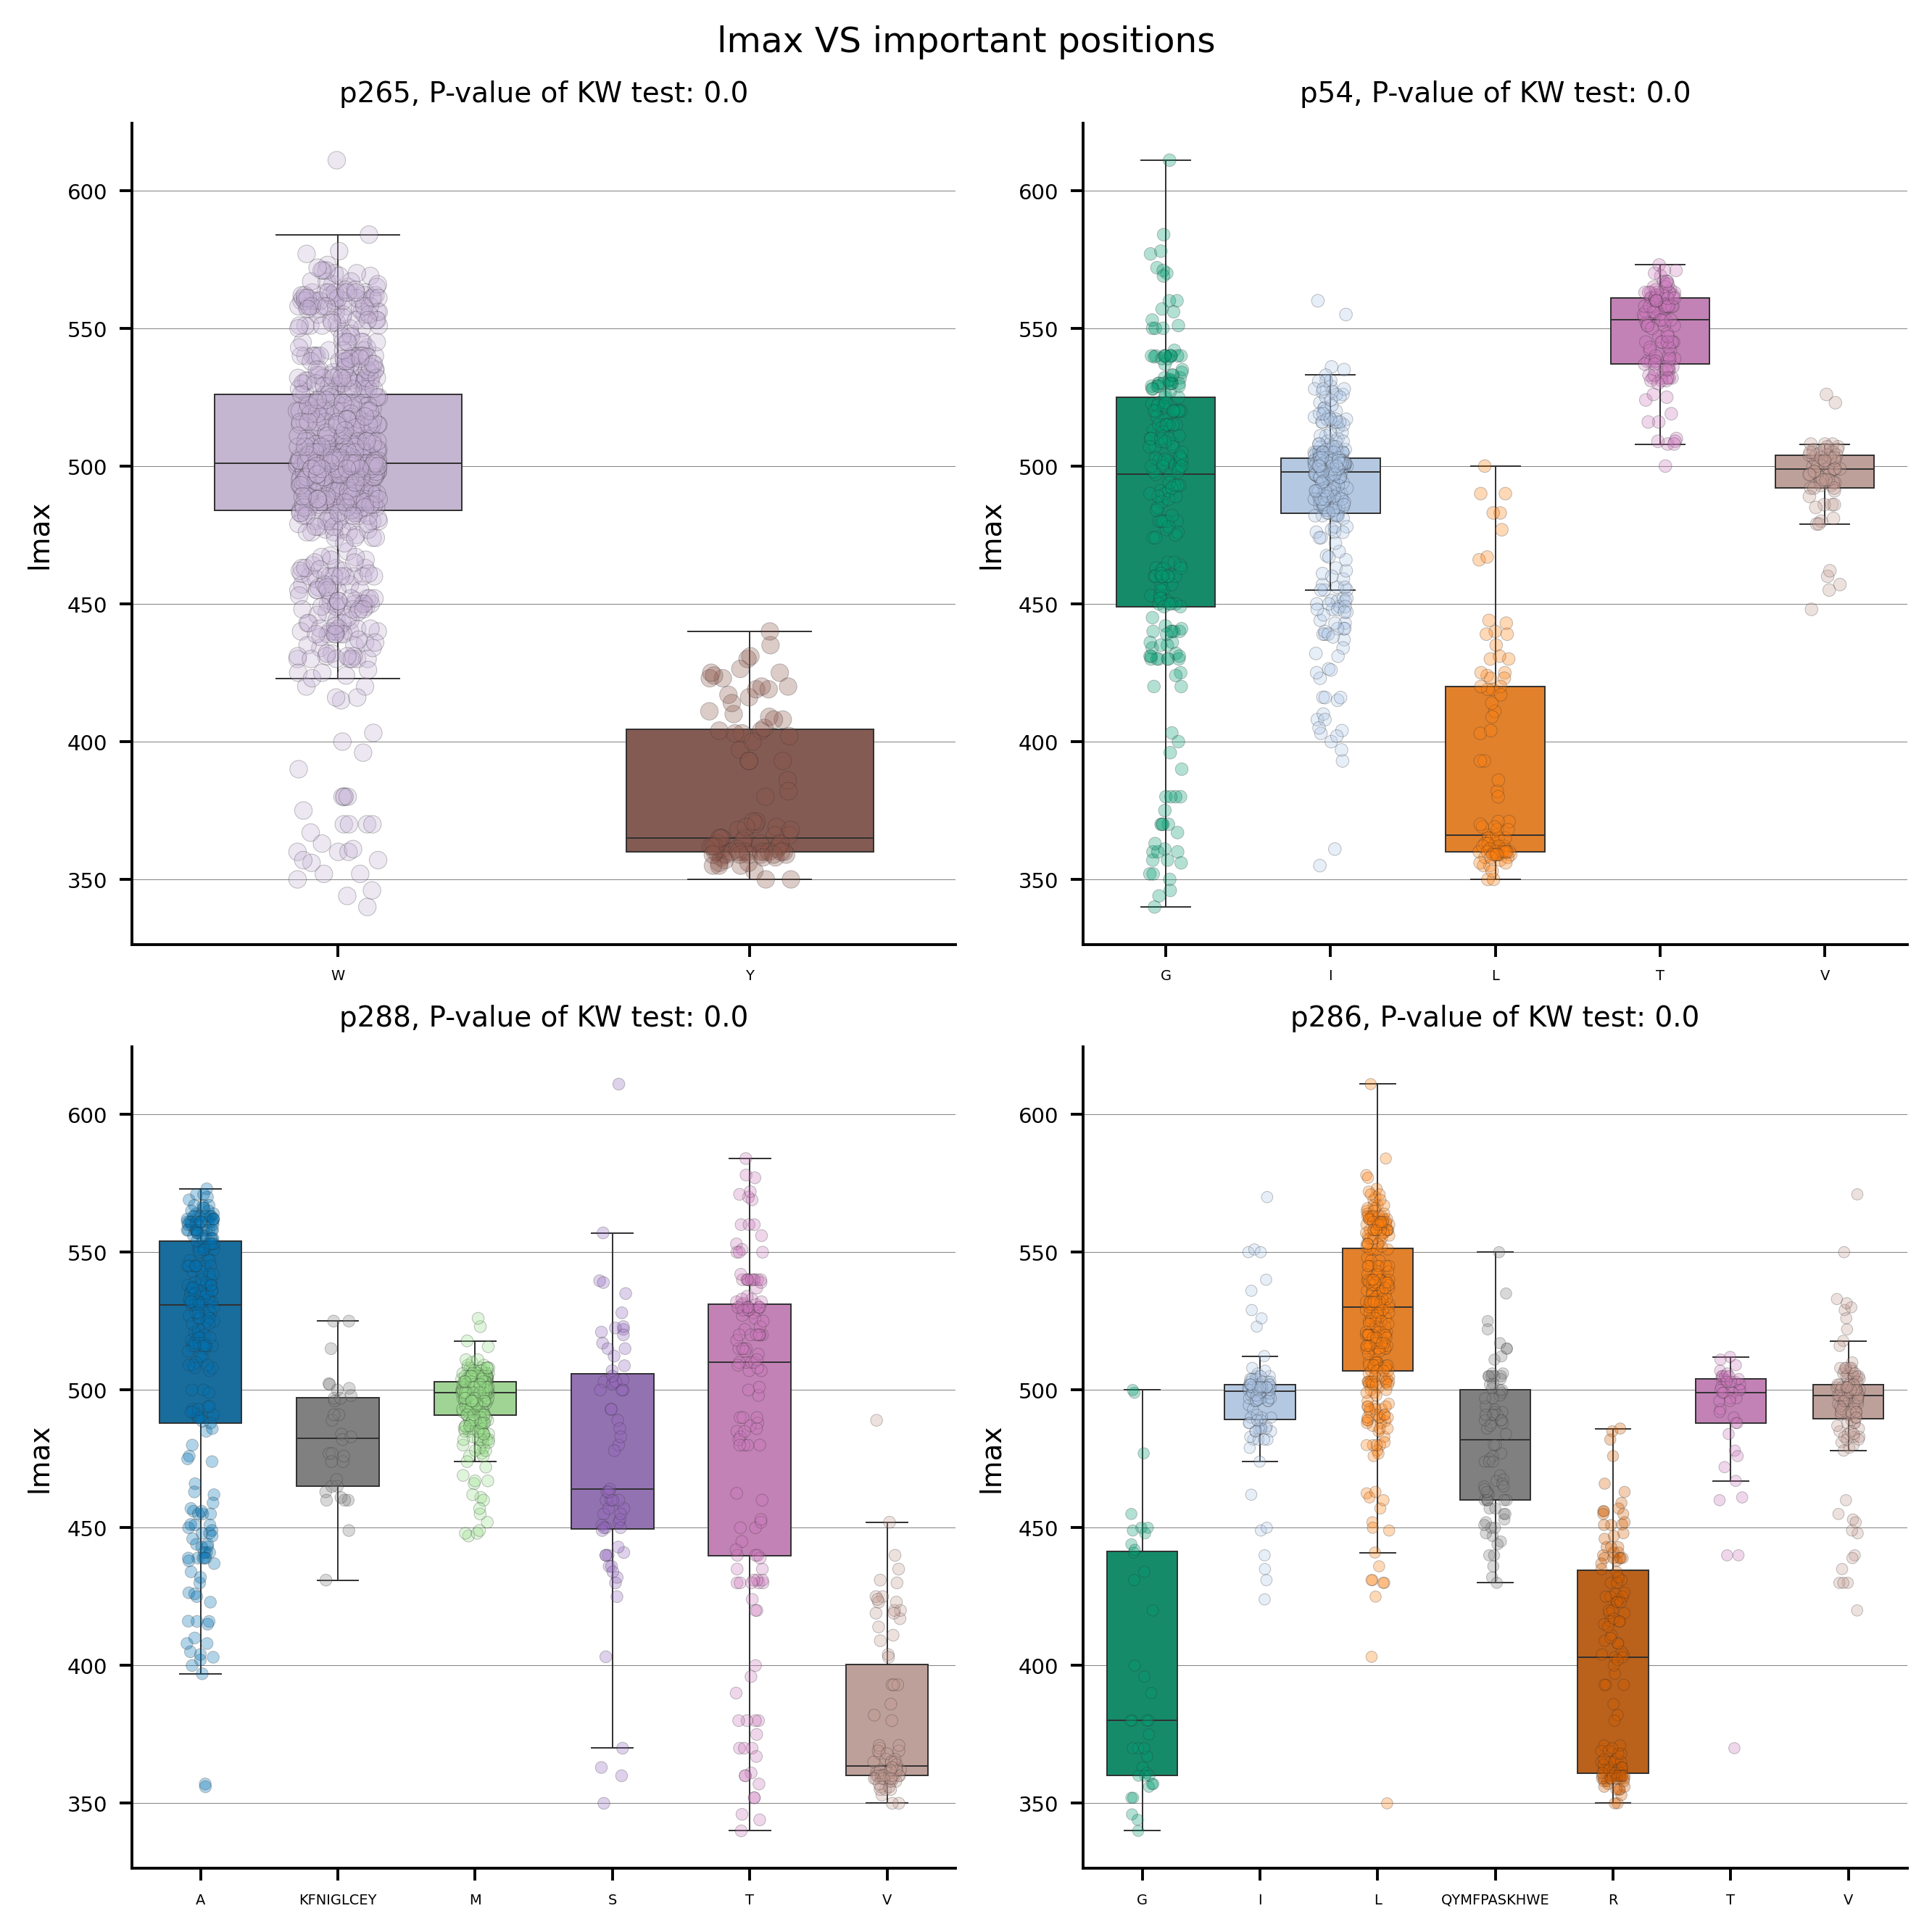

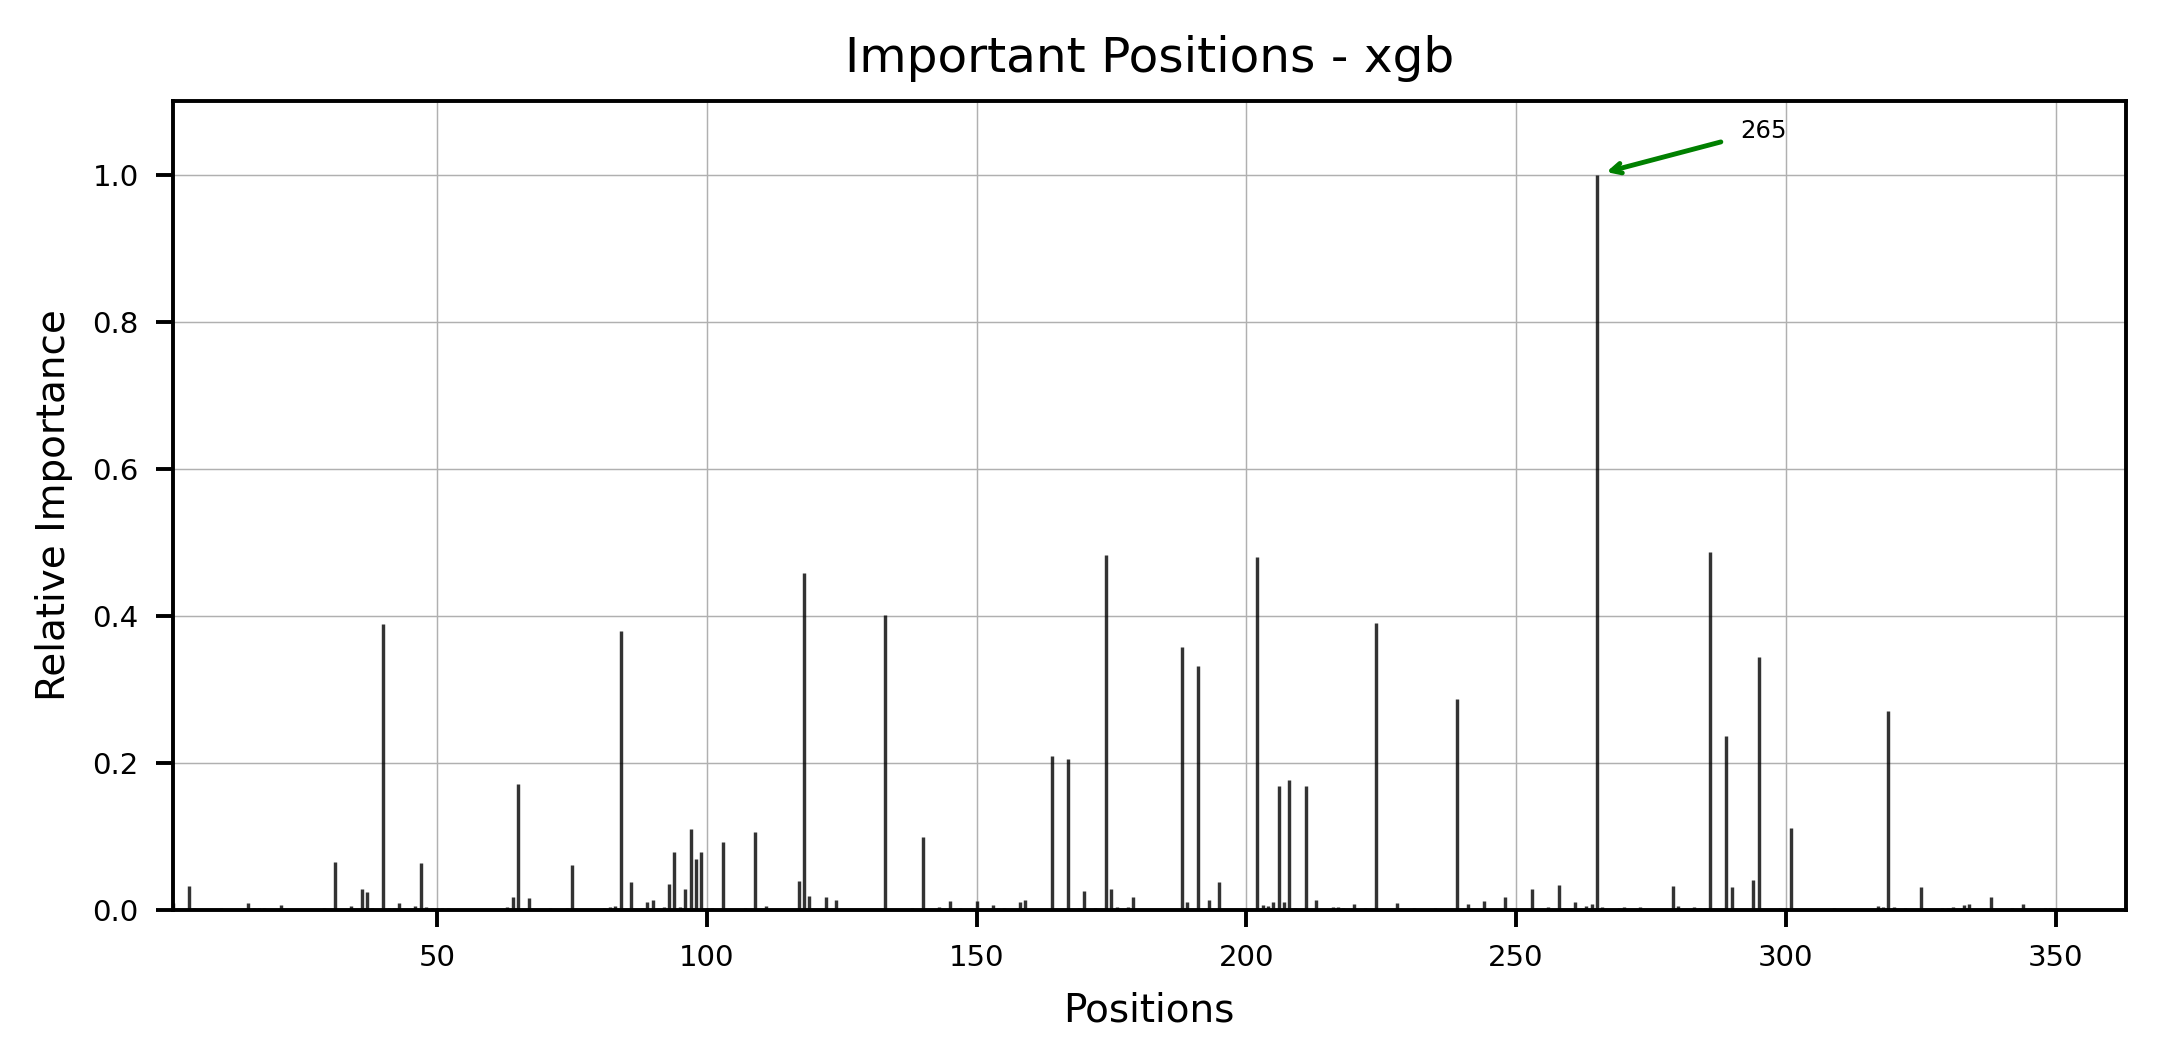

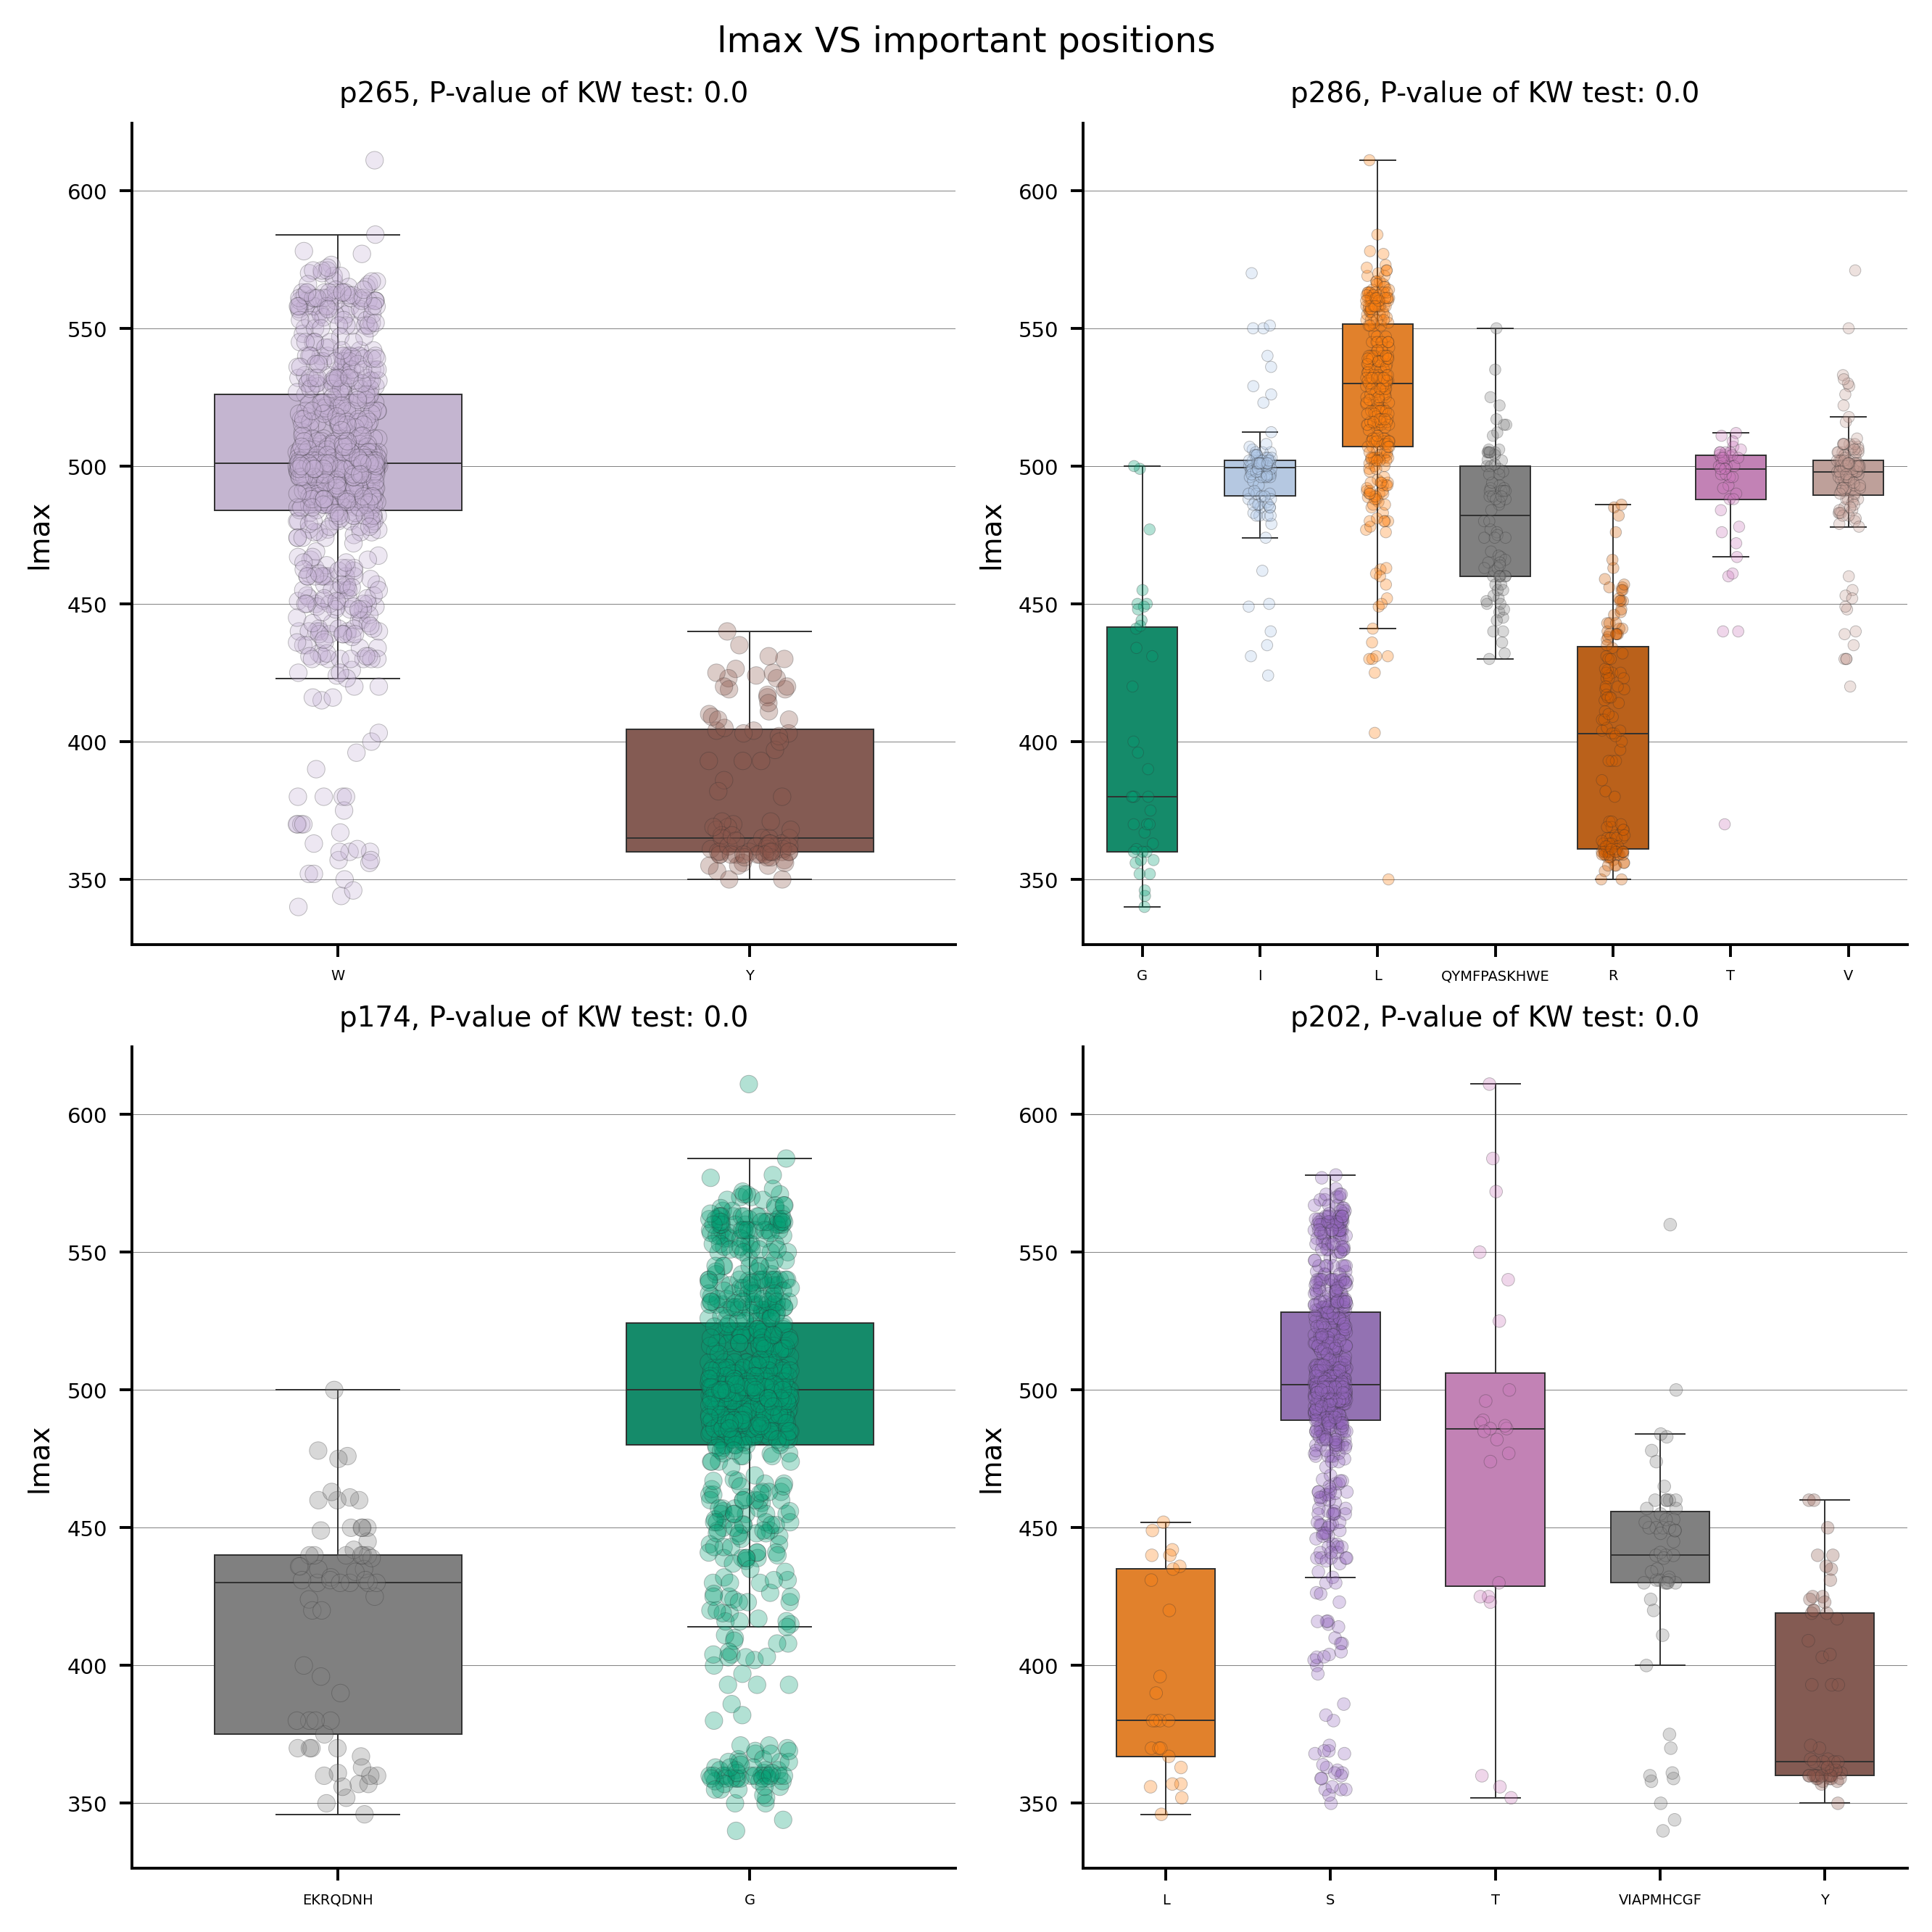

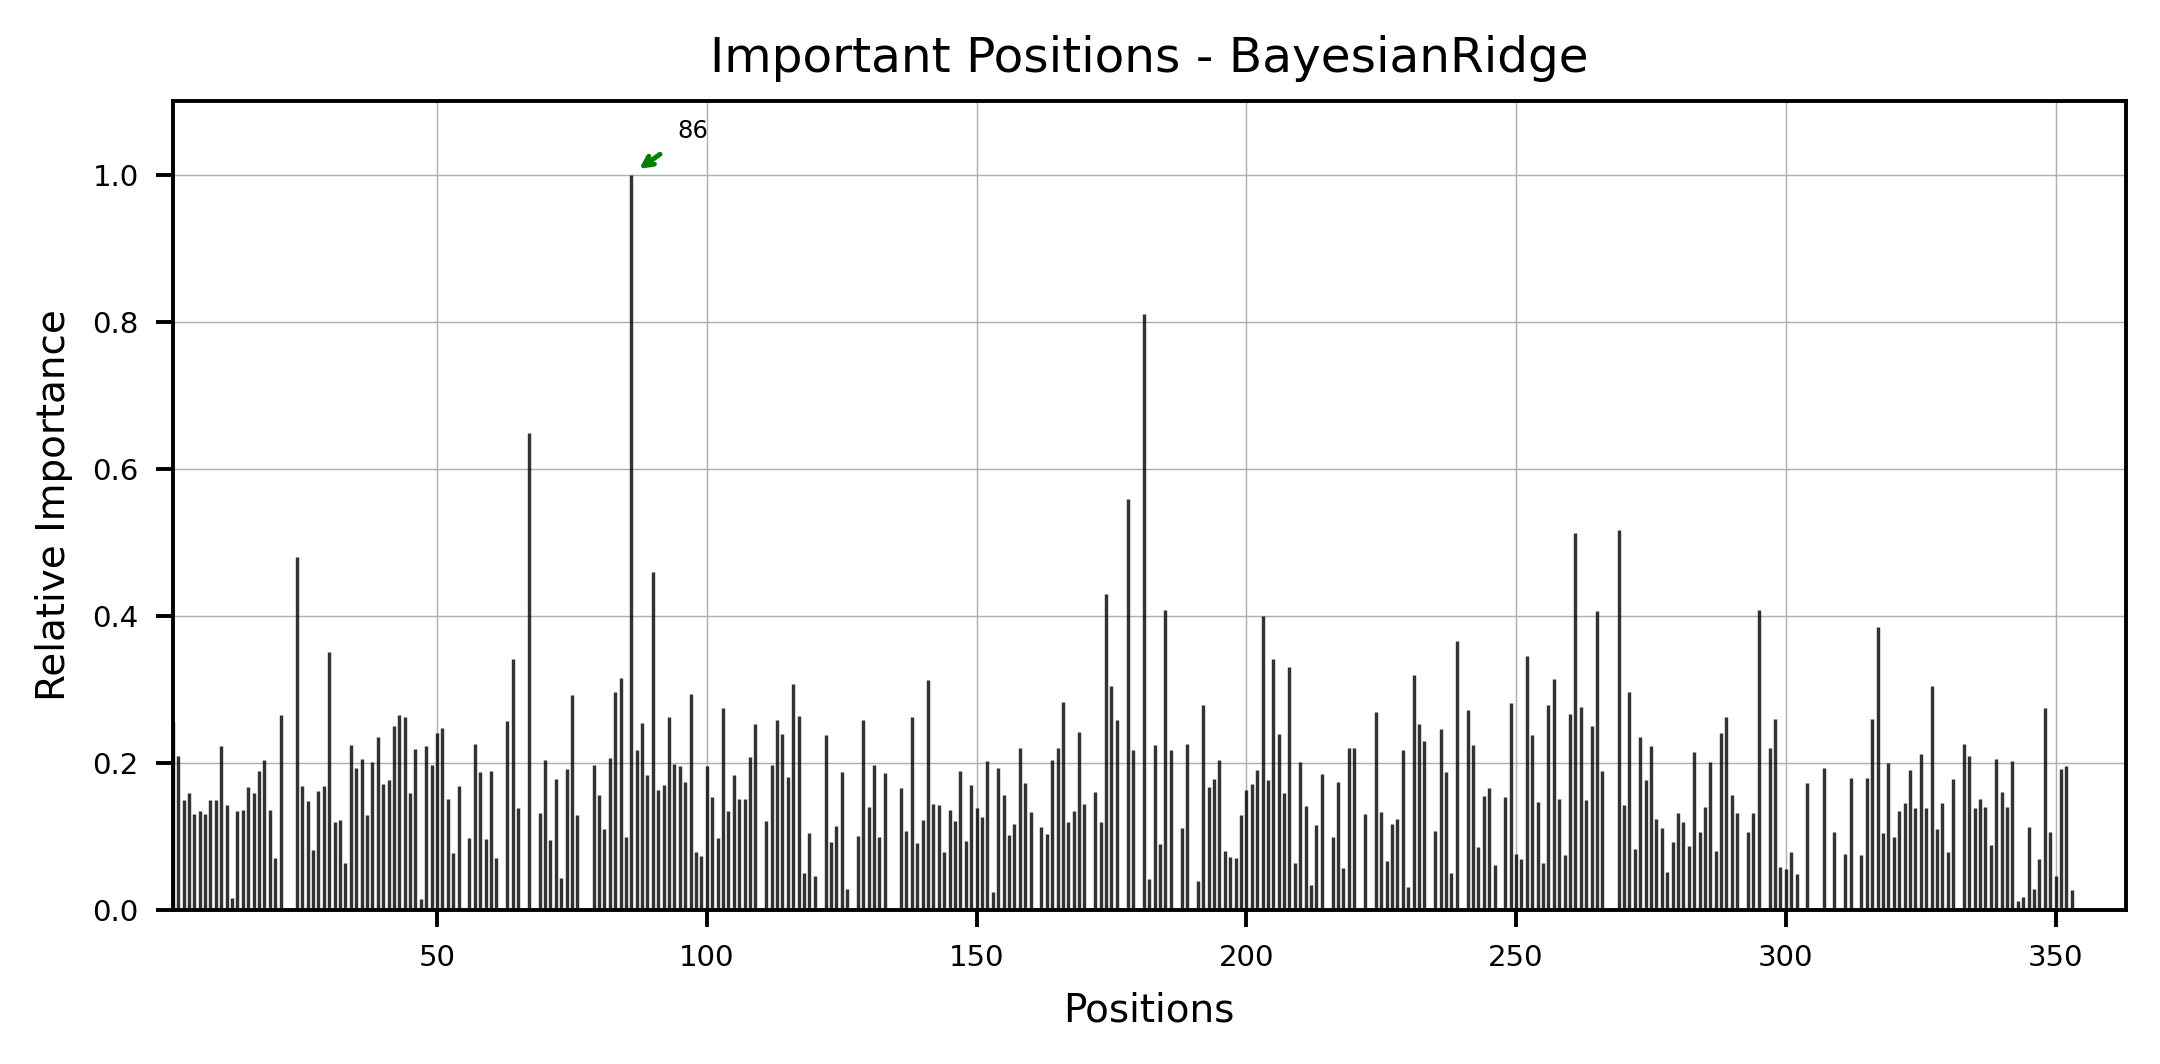

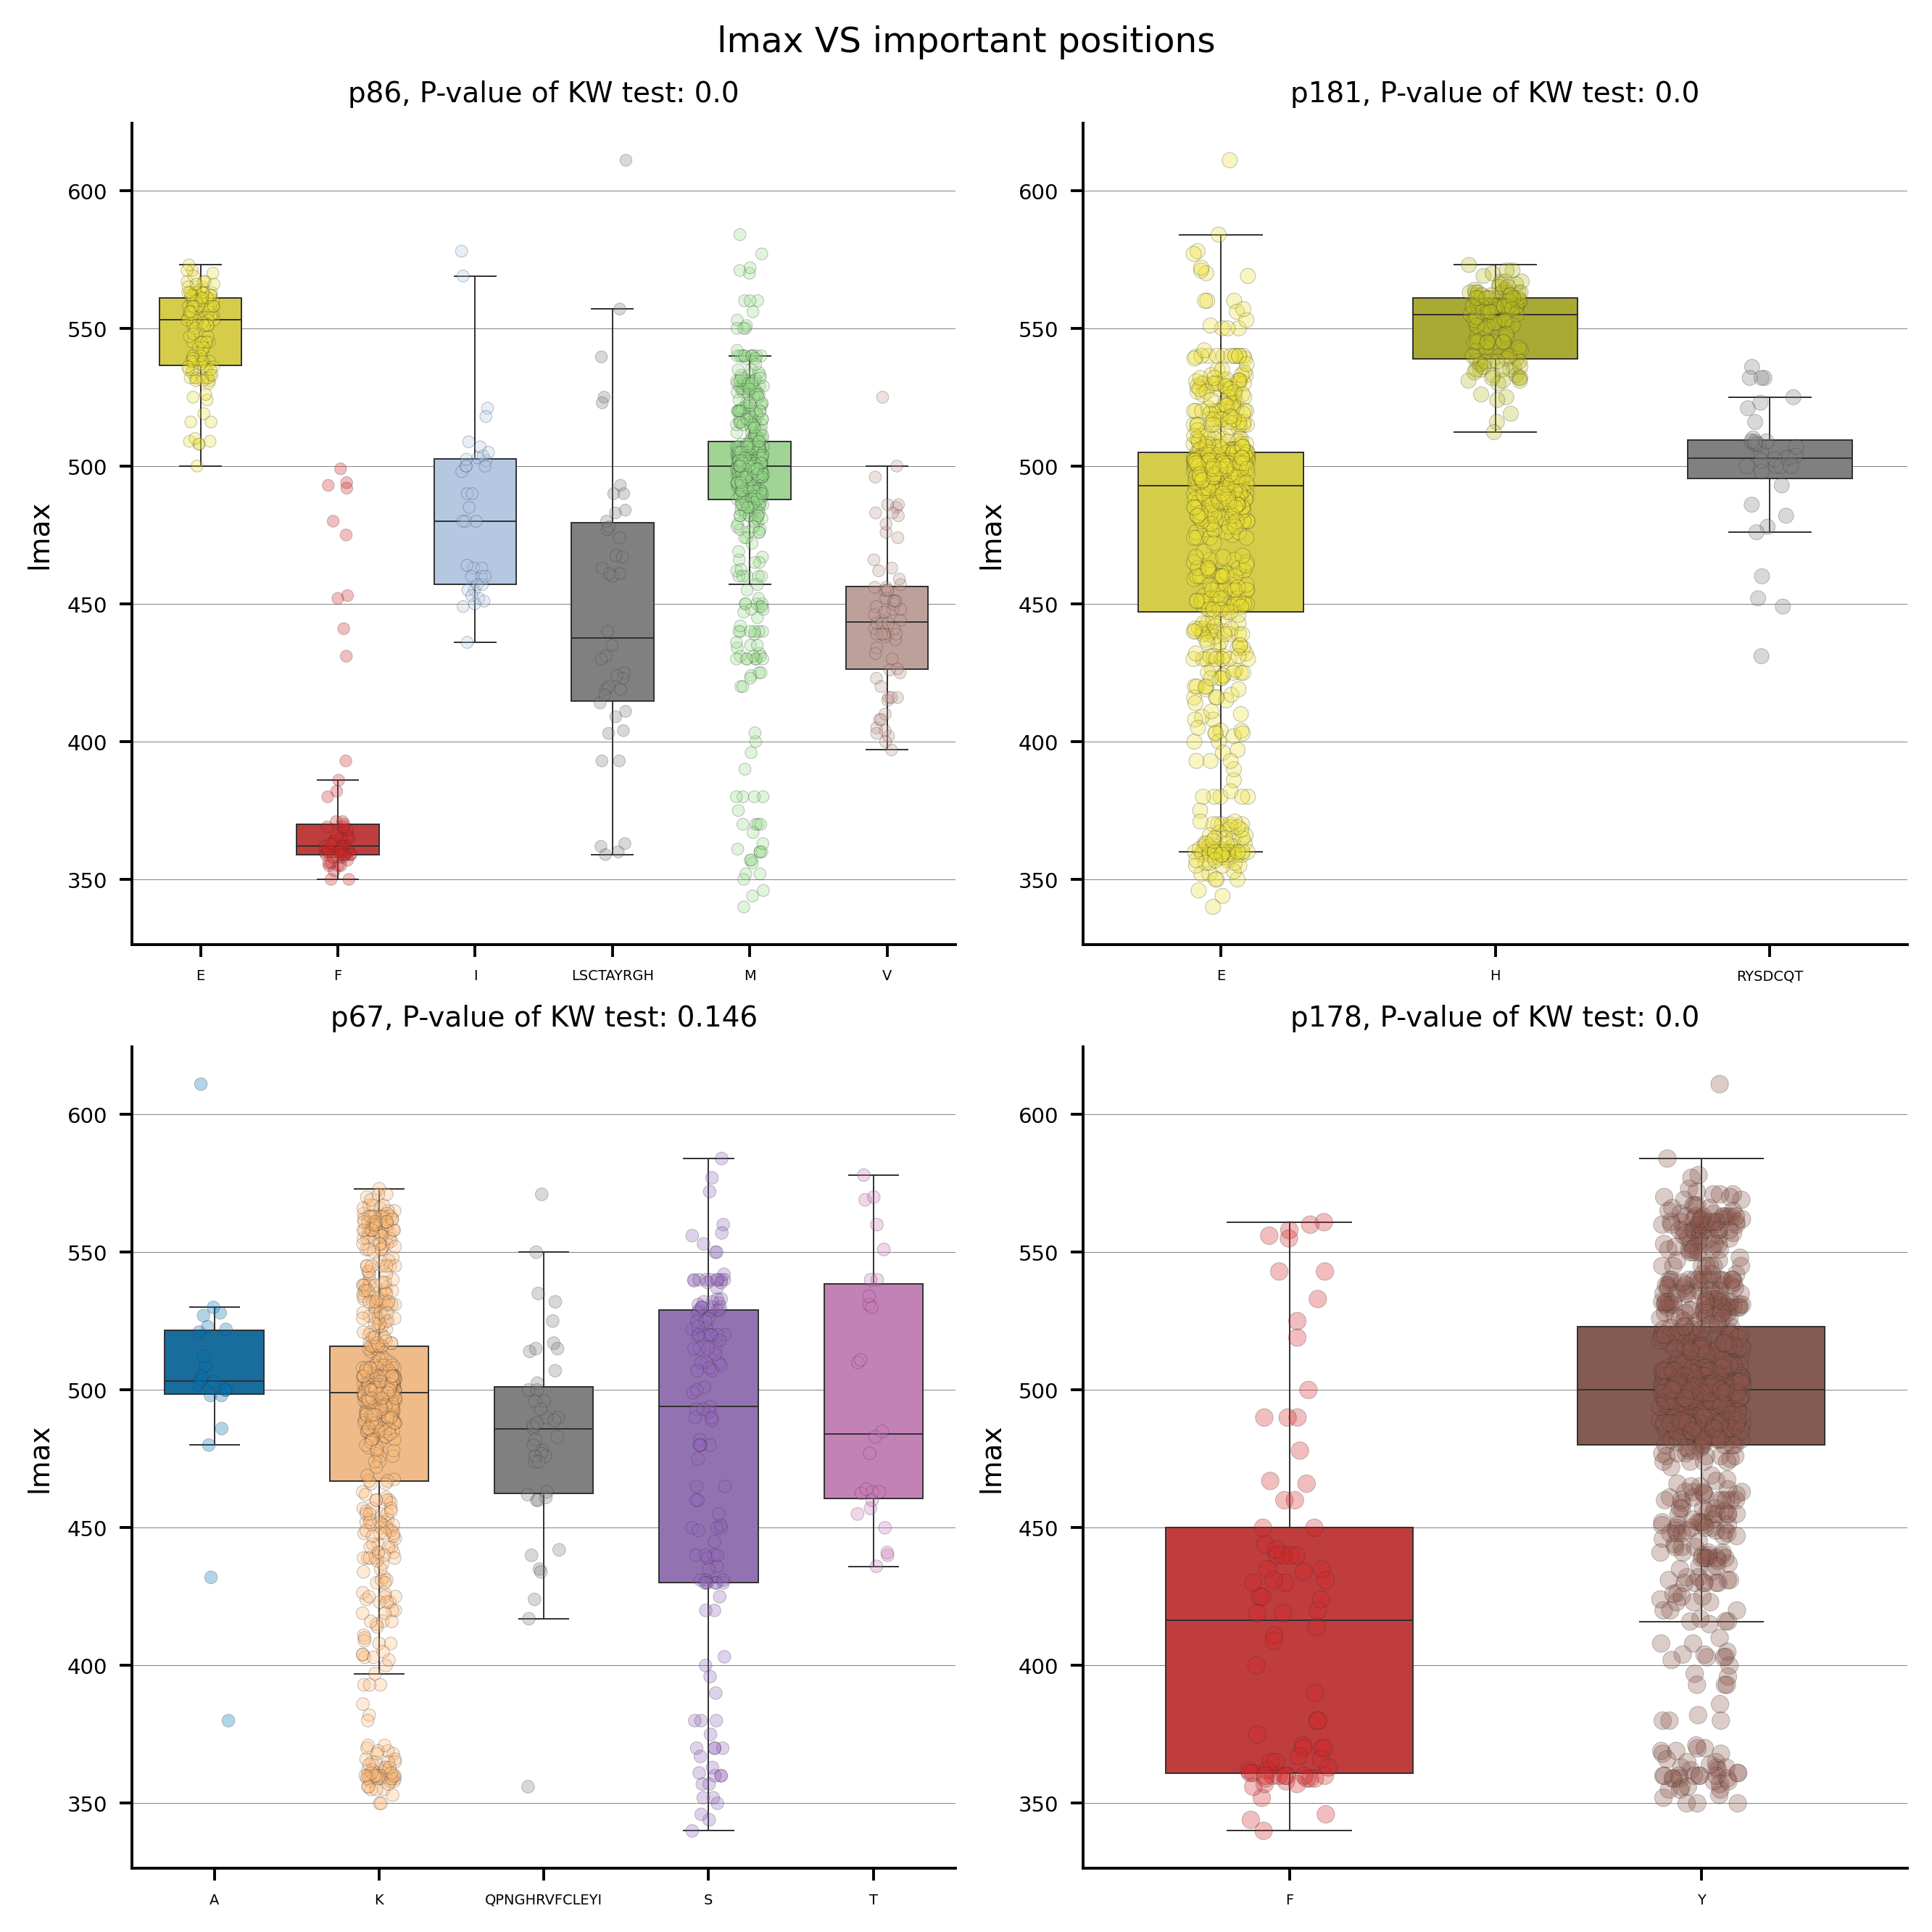

In [34]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=test_copy, y_train=y, model_name=model_name,
                   meta_var='lmax', model_type=ana_type, report_dir=report_dir)

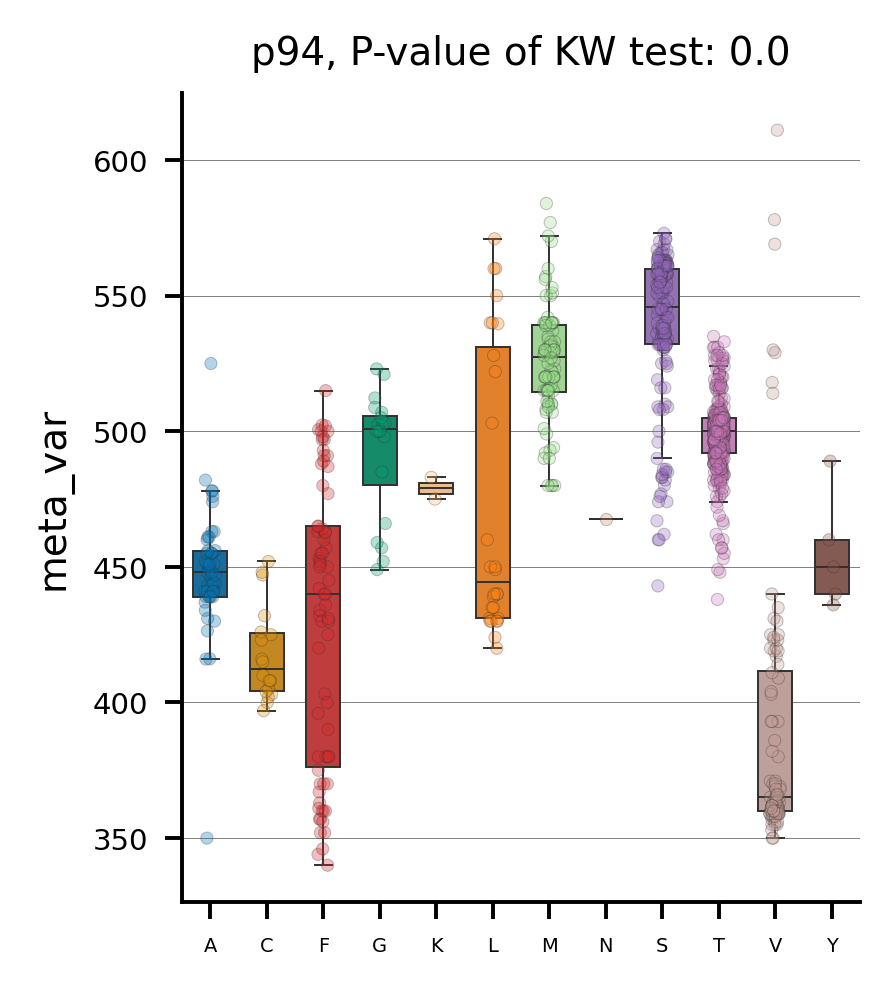

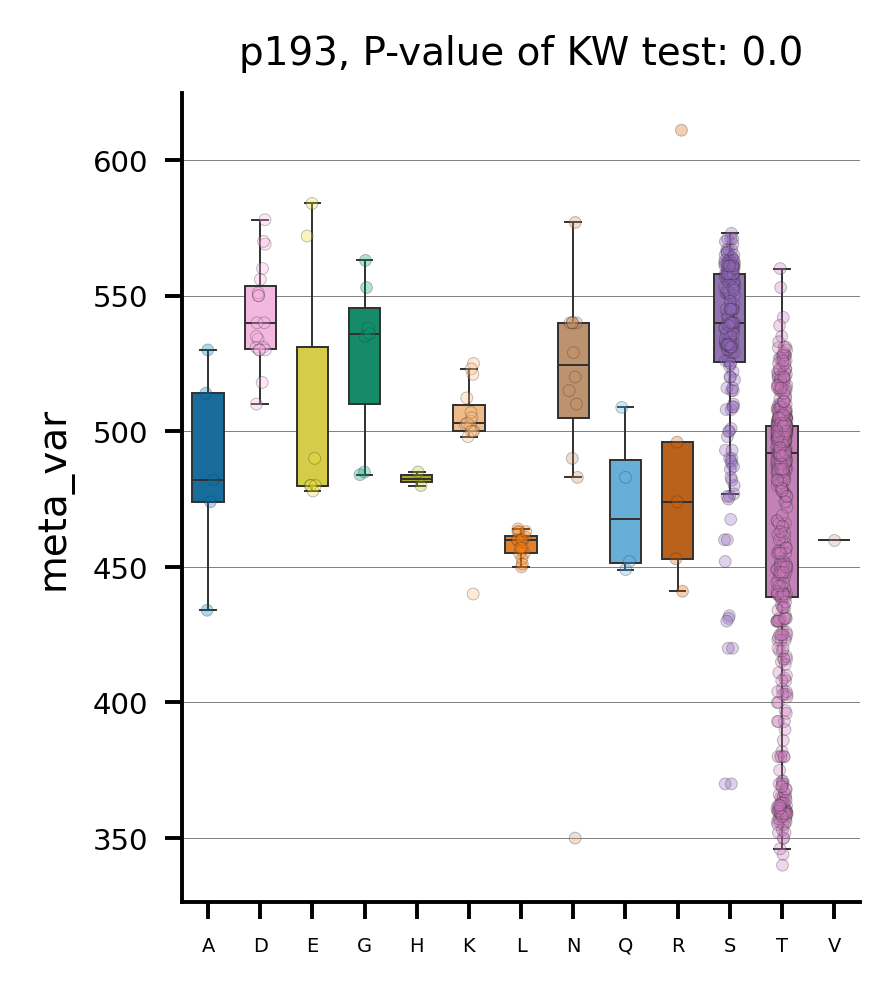

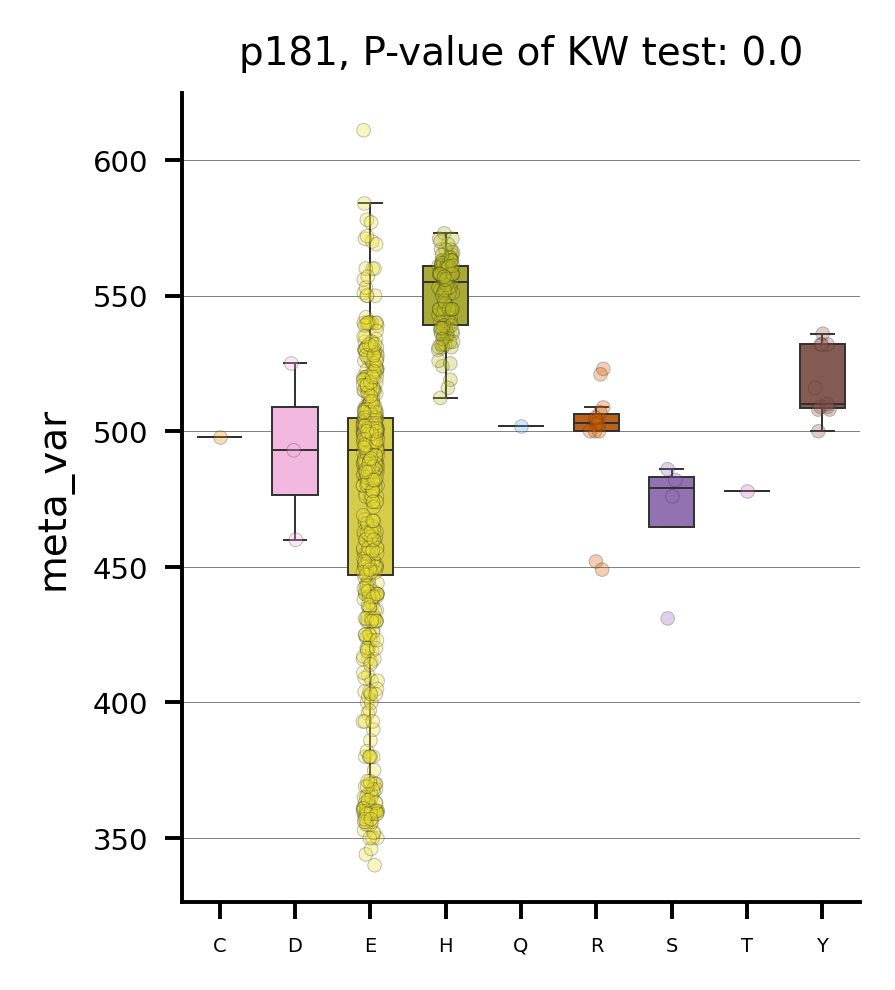

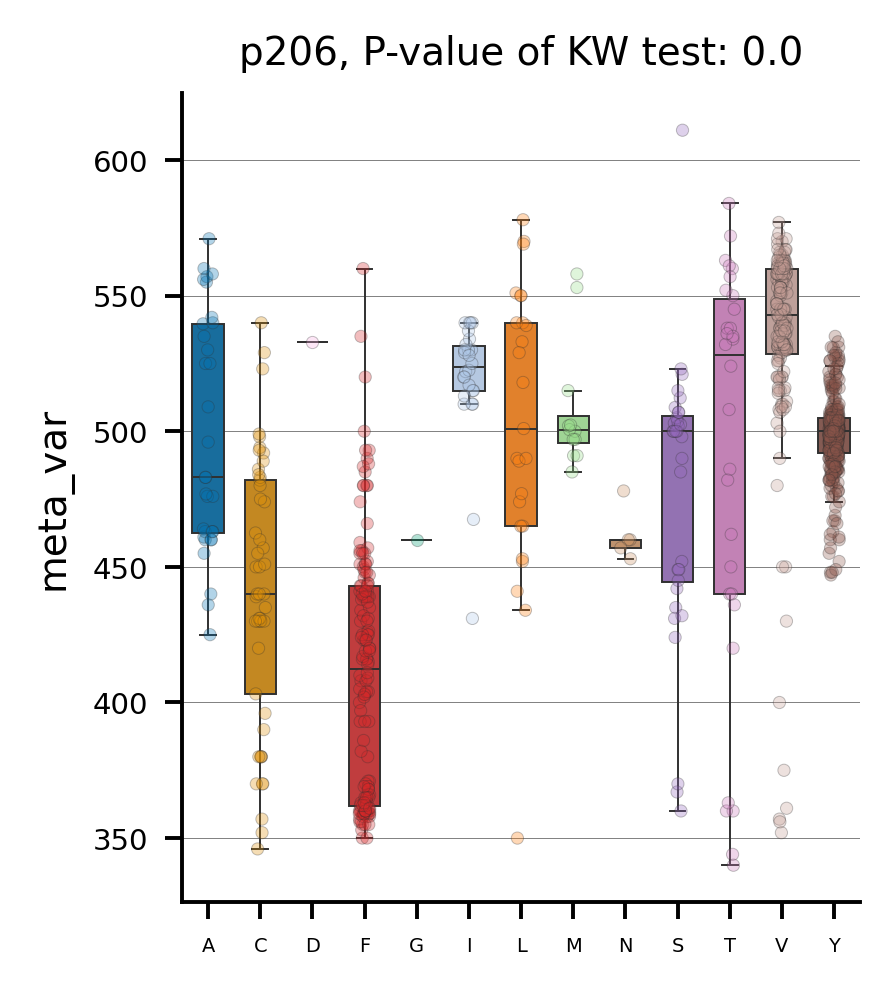

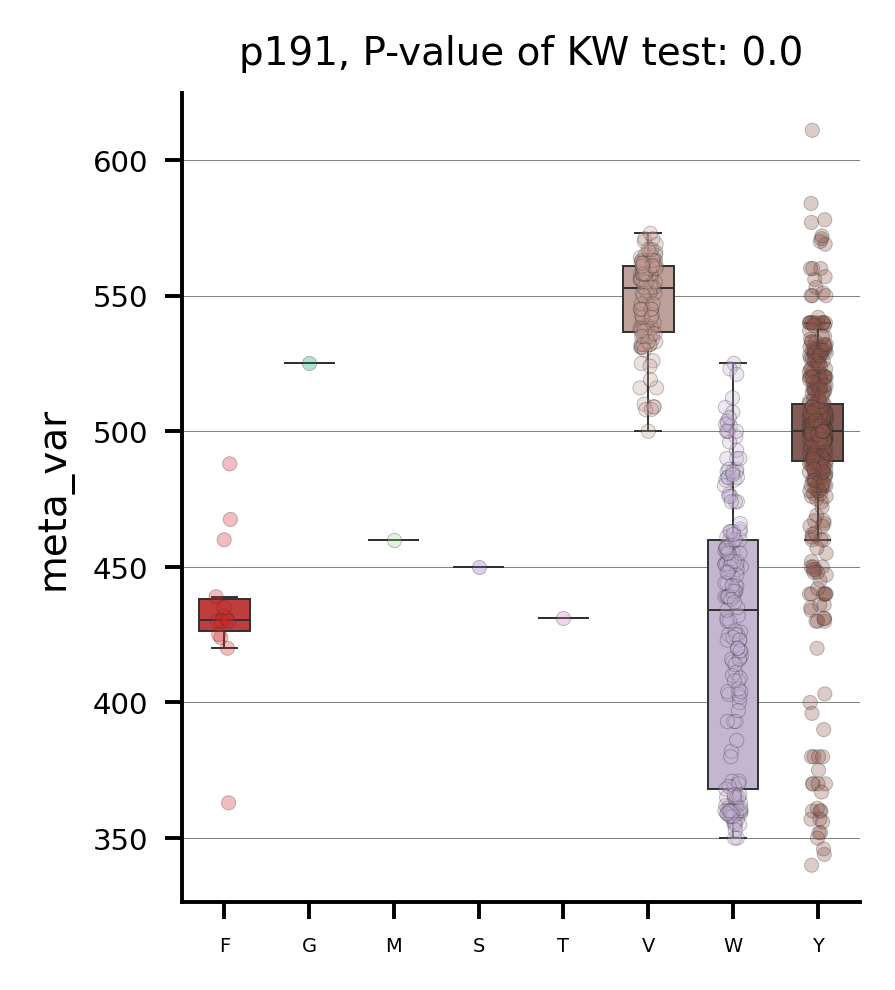

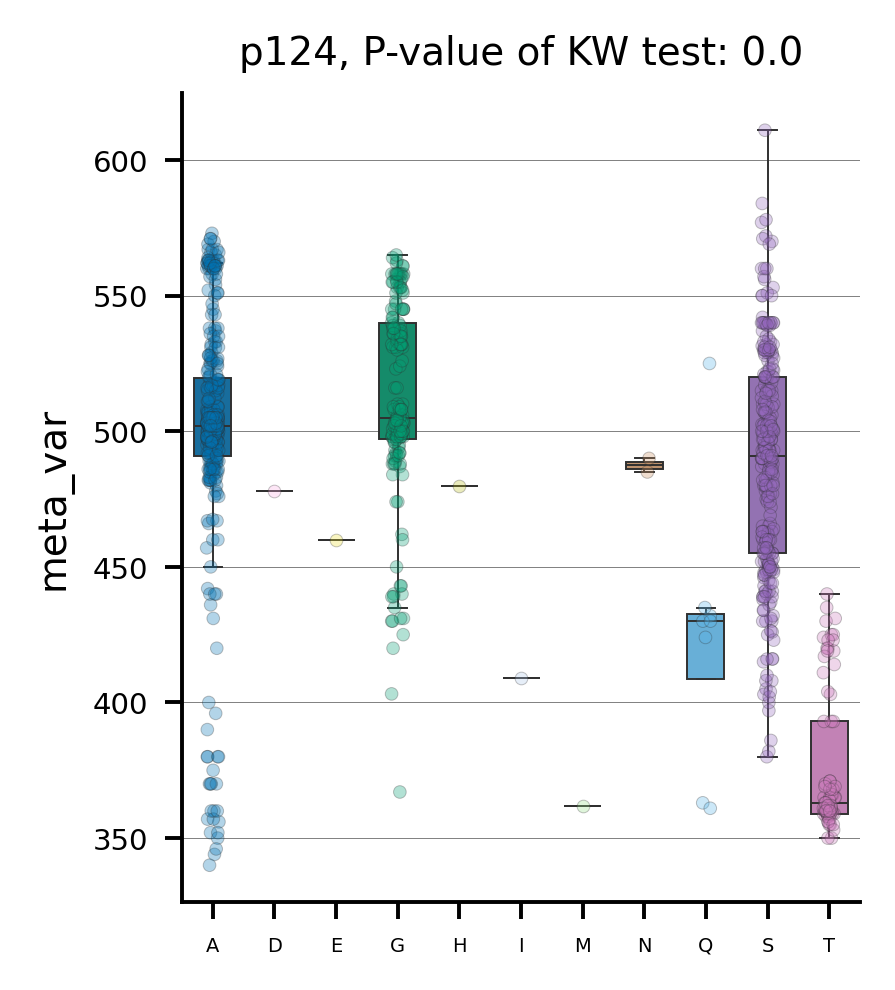

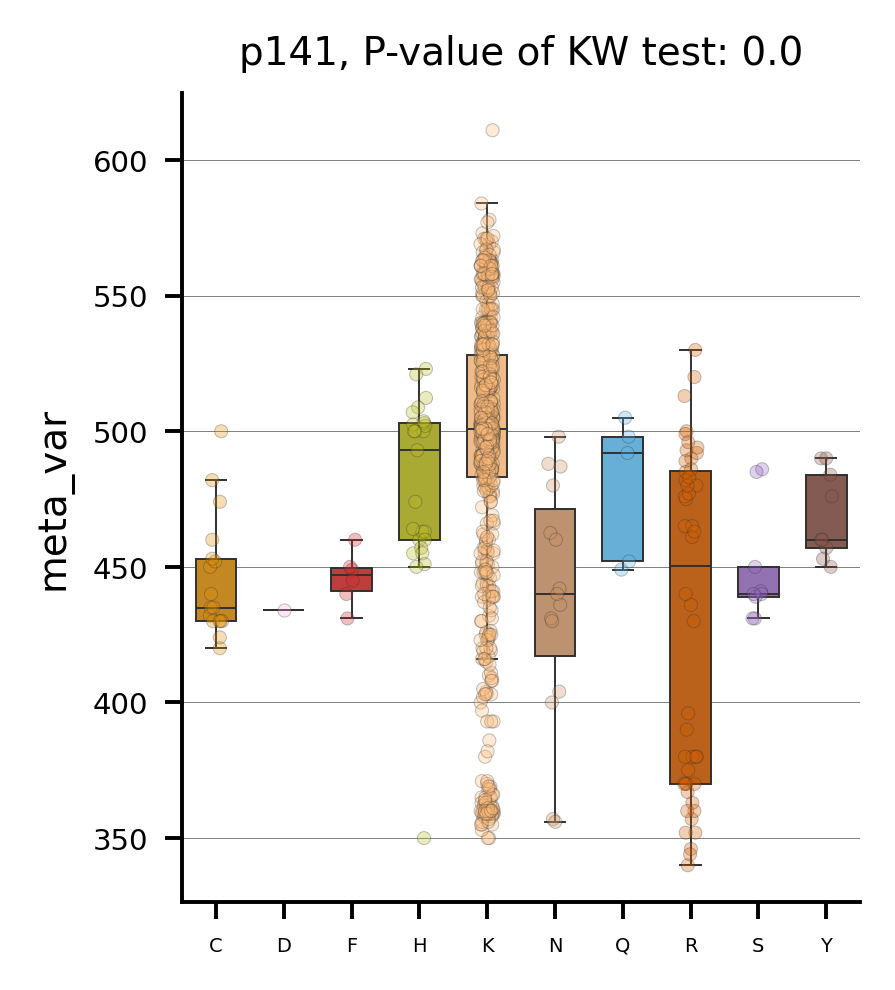

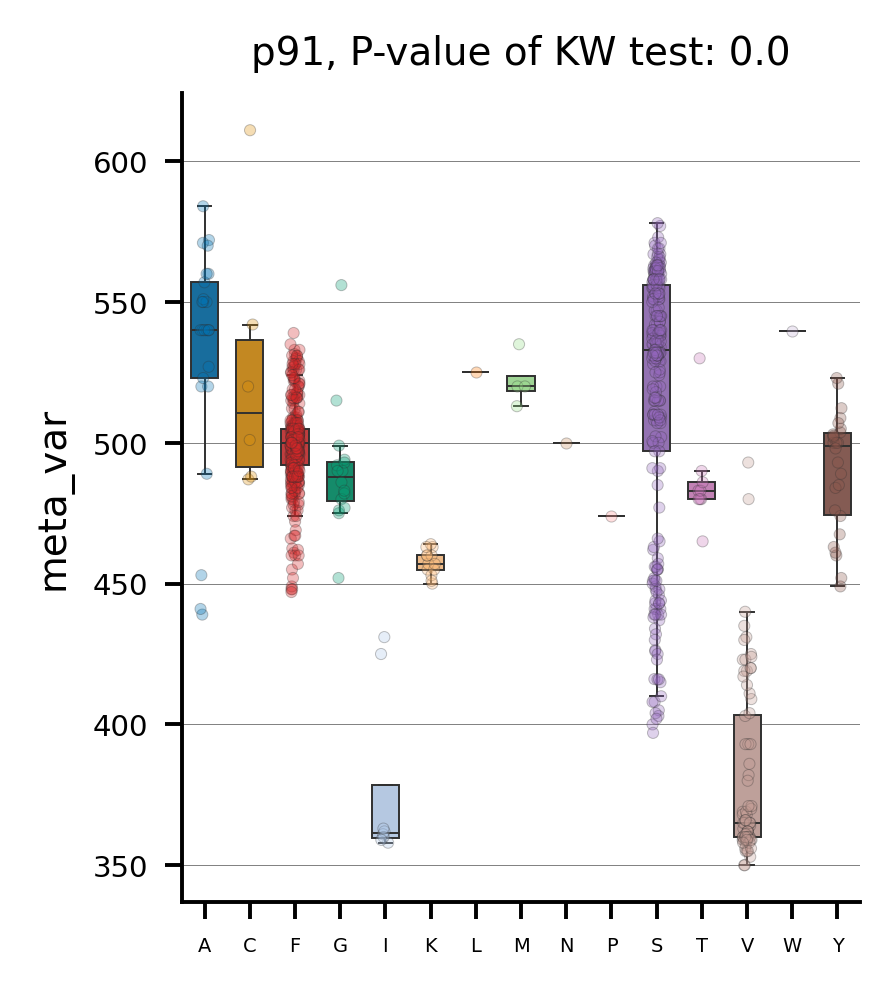

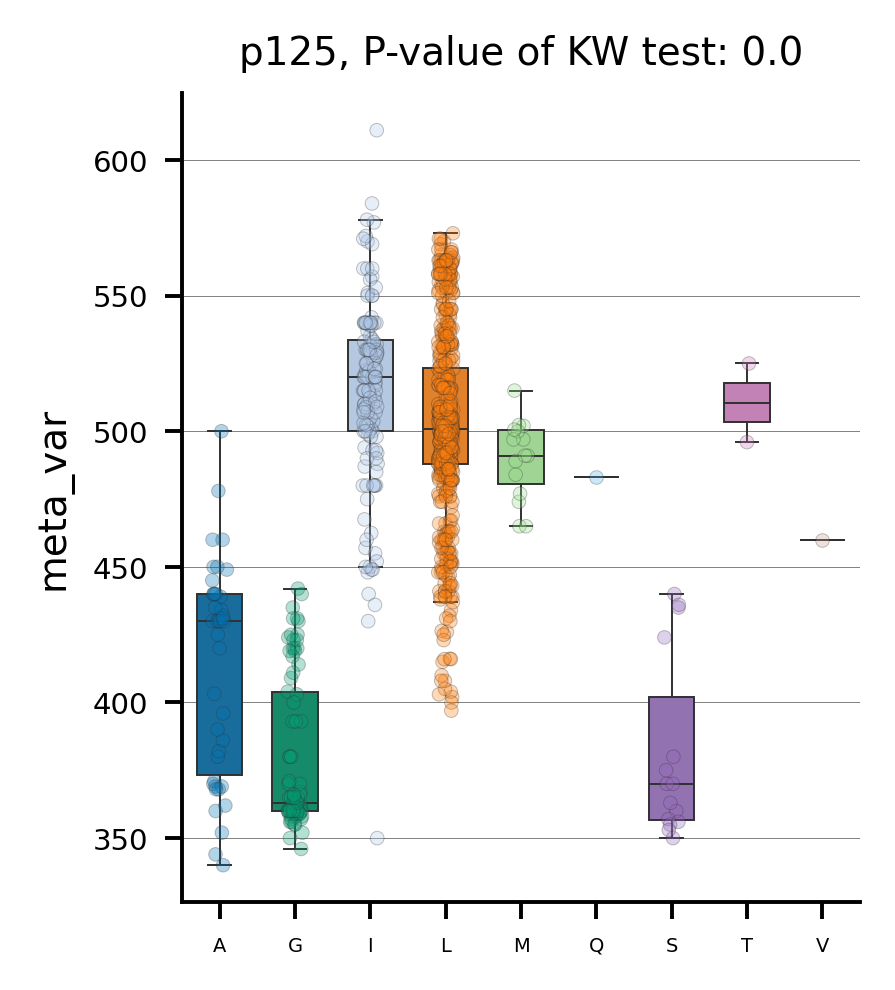

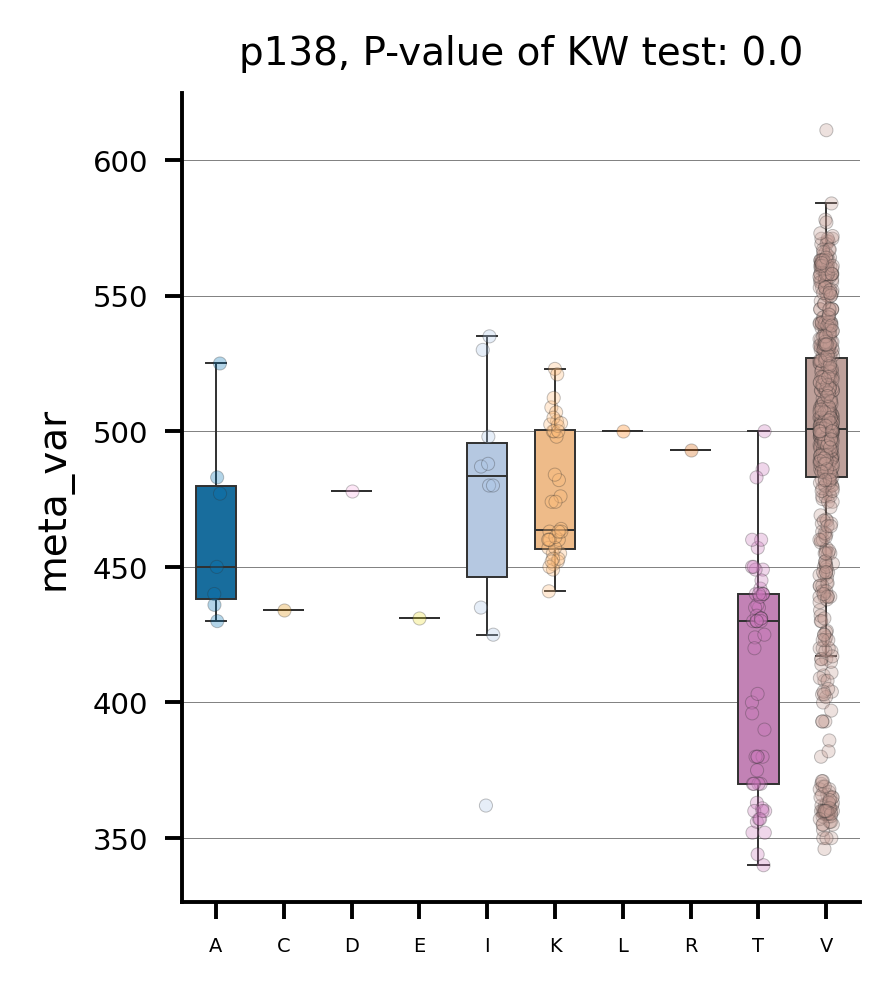

In [35]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=10,
                  figsize=(2.5, 3))

# <font color=#c994c7>Step 4: Translate Candidate Spectral Tuning Sites (STS)</font> 
### This section is used to translate candidate STS to the bovine or squid equivalent.
 - The bovine and squid sequence dataframes that were saved earlier and are called again here


In [58]:
import pandas as pd
from vpod_scripts.translate_candidate_sts import translate_candidate_sts

trans_imp_report = translate_candidate_sts(report_dir, ref_seq_name, reference_seq)
trans_imp_report.head()

Unnamed: 0  feature       gbr        rf       xgb  BayesianRidge      mean  \
0           0        1  0.019329  0.019434  0.009157       0.255007  0.075732   
1           1        2  0.003247  0.006433  0.001531       0.209272  0.055121   
2           2        3  0.002715  0.005554  0.000353       0.148680  0.039325   
3           3        4  0.033042  0.048904  0.032196       0.159177  0.068330   
4           4        5  0.002781  0.007520  0.002392       0.130556  0.035813   

  true_position        TMD amino_acid  
0             1      CT/EC          M  
1             2      CT/EC          N  
2             3  N-Termina          G  
3             4  N-Termina          T  
4             5  N-Termina          E